<a href="https://colab.research.google.com/github/christinacdl/Thesis_Detection_of_Offensive_Language/blob/main/Task_10_Sexism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SemEval 2023 - Task 10 - Explainable Detection of Online Sexism (EDOS)**

**Christodoulou Christina**




## **ABSTRACT**
---
The paper describes the SemEval-2023 Task 10: *Explainable Detection of Online Sexism (EDOS)*, which investigates the detection of sexism on two social media sites, Gab and Reddit, by encouraging the development of machine learning models that perform binary and multi-class classification on English texts. The EDOS Task consisted of three hierarchical sub-tasks: binary sexism detection in sub-task A, category of sexism detection in sub-task B and fine-grained vector of sexism detection in sub-task C. My participation in EDOS comprised fine-tuning of different layer representations of Pre-trained Transformer models, namely ALBERT-xxlarge-v2, ALBERT-xxlarge-v1, BERT$_{LARGE}$ and RoBERTa$_{LARGE}$, and ensemble learning via majority voting of the best performing models. Despite the low rank mainly due to a submission error, the system paper provides an intuitive approach towards employing the largest version of Transformer models, experimenting with their multi-layer structure and aggregating their predictions so as to get the final result. My predictions on the test sets achieved 82.88\%, 63.77\% and 43.08\% macro F1 score in sub-tasks A, B and C respectively.
 
 **KEYWORDS:** sexism detection, social media, NLP, machine learning, Transformers, text classification, ensemble learning 




In [ ]:

from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install  transformers emoji ekphrasis -U SentencePiece focal_loss_torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import necessary libraries
import argparse
import torch
from torchtext import data, datasets
import random
import re 
import glob 
import spacy
import string 
import time
import emoji
import pandas as pd  
import seaborn as sns
import math
import numpy as np
import nltk
import pickle
from tqdm import tqdm, trange
import datetime
import torch.nn as nn
import torch.optim as optim
import collections
from sklearn.utils import resample
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,  matthews_corrcoef
from sklearn.metrics import classification_report
from functools import reduce
import os
import copy
import shutil
import torch.nn.functional as F
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import itertools
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler 
from transformers import AdamW, get_linear_schedule_with_warmup, BertTokenizer, BertModel,BertConfig, AlbertConfig, AlbertModel, AlbertTokenizer, RobertaModel, RobertaTokenizer, RobertaConfig, BertForSequenceClassification
import matplotlib.pyplot as plt 
from sklearn.model_selection import StratifiedKFold
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
import torchvision
from typing import Callable
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.utils.class_weight import compute_class_weight
from focal_loss.focal_loss import FocalLoss

# Download necessary packages
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
torch.cuda.empty_cache()
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |\n|       from large pool |       0 B  |       0 B  |

In [ ]:
# Set up GPU for Training
if torch.cuda.is_available():       
  device = torch.device('cuda')
  print(f'There are {torch.cuda.device_count()} GPU(s) available.')
  print('Device name:', torch.cuda.get_device_name(0))
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
Device name: NVIDIA A100-SXM4-40GB


**THE LABELS FOR ALL TASKS**

In [ ]:
# Determine the number of labels in the data and map each of these labels to an index. There are 2 labels: Not Offensive (NOT) and Offensive (OFF)
# TASK A
labels_to_id_task_a = {'not sexist': 0 ,'sexist': 1}
id_to_labels_task_a = {0: 'not sexist', 1: 'sexist'}
print(f'TASK A LABELS: \n {labels_to_id_task_a}')
# TASK B
labels_to_id_task_b = {'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3}
id_to_labels_task_b = {0 :'1. threats, plans to harm and incitement', 1 :'2. derogation', 2: '3. animosity', 3: '4. prejudiced discussions'}
print(f'TASK B LABELS: \n {labels_to_id_task_b}')
# TASK C
labels_to_id_task_c = {'1.1 threats of harm' : 0, '1.2 incitement and encouragement of harm' : 1, '2.1 descriptive attacks' : 2, '2.2 aggressive and emotive attacks' : 3, '2.3 dehumanising attacks & overt sexual objectification' : 4, '3.1 casual use of gendered slurs, profanities, and insults' : 5, '3.2 immutable gender differences and gender stereotypes' : 6, '3.3 backhanded gendered compliments' : 7, '3.4 condescending explanations or unwelcome advice' : 8, '4.1 supporting mistreatment of individual women' : 9, '4.2 supporting systemic discrimination against women as a group' : 10}
id_to_labels_task_c = {0 : '1.1 threats of harm', 1 : '1.2 incitement and encouragement of harm', 2 : '2.1 descriptive attacks', 3 : '2.2 aggressive and emotive attacks', 4 :'2.3 dehumanising attacks & overt sexual objectification', 5 : '3.1 casual use of gendered slurs, profanities, and insults', 6 : '3.2 immutable gender differences and gender stereotypes', 7 : '3.3 backhanded gendered compliments', 8 : '3.4 condescending explanations or unwelcome advice', 9 : '4.1 supporting mistreatment of individual women', 10 : '4.2 supporting systemic discrimination against women as a group'}
print(f'TASK C LABELS: \n {labels_to_id_task_c}')

TASK A LABELS: 
 {'not sexist': 0, 'sexist': 1}
TASK B LABELS: 
 {'1. threats, plans to harm and incitement': 0, '2. derogation': 1, '3. animosity': 2, '4. prejudiced discussions': 3}
TASK C LABELS: 
 {'1.1 threats of harm': 0, '1.2 incitement and encouragement of harm': 1, '2.1 descriptive attacks': 2, '2.2 aggressive and emotive attacks': 3, '2.3 dehumanising attacks & overt sexual objectification': 4, '3.1 casual use of gendered slurs, profanities, and insults': 5, '3.2 immutable gender differences and gender stereotypes': 6, '3.3 backhanded gendered compliments': 7, '3.4 condescending explanations or unwelcome advice': 8, '4.1 supporting mistreatment of individual women': 9, '4.2 supporting systemic discrimination against women as a group': 10}


**FUNCTIONS USED**

In [ ]:
# A function that sets seed for reproducibility
def set_seed(seed_value): 
  random.seed(seed_value)
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  torch.cuda.manual_seed_all(seed_value)


# A function that calculates time in seconds and returns a string in the form hh:mm:ss
def calculate_time(elapsed_time):  
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed_time)))  
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


# A function that calculates the trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


# A function that checks if a directory exists else creates the directory 
def check_create_path(path): 
  if not os.path.exists(path):
    os.makedirs(path)
    print('Directory created at {}'.format(path))
  else:
    print('Directory {} already exists!'.format(path))


# A function that reads a csv or tsv file, removes missing values and duplicates 
def read_a_file(filename, labelled_dataset = True):
  
  # Check first whether a certain file or directory exists
  if os.path.exists(filename):
    print('Current file opened: ',[os.path.join(filename, file) for file in glob.glob(filename)])
    
    # Find the file extension to open it properly
    find_separator = {'.csv': ',', '.tsv': '\t'}
    basename, format = os.path.splitext(filename)
    assert format in find_separator
    separator = find_separator[format]

    # Read different extensions of files using pandas with 2 different separators     
    read_file = pd.read_csv(filename, sep = separator, encoding = 'utf-8')
      
    # Get the keys and their corresponding number of values
    keys = read_file.keys() 
    for key in keys:
      df_len = len(read_file[key].unique()) # the length of the unique values of each column
      print('{0:25}{1:10}'.format(key,df_len))

    # Remove missing values and keep the dataFrame with valid entries in the same variable
    read_file.dropna(inplace = True) 
      
    # Remove the index
    read_file.reset_index(inplace = True, drop = True)

    read_file.info()

    if labelled_dataset:
      # Encode the concatenated data
      encoded_texts = [tokenizer.encode(sent, add_special_tokens = True) for sent in read_file.text.values]

      # Find the maximum length
      max_len = max([len(sent) for sent in encoded_texts])
      print('Maximum sentence length: ', max_len)

      # Find the minimum length
      min_len = min([len(sent) for sent in encoded_texts])
      print('Minimum sentence length: ', min_len)
    
    else:
      None  
    
    return read_file

  else:
    print('File or directory not accessible. Please check the entered path of the file.')

In [ ]:
# MY FUNCTIONS FOR DATA PREPROCESSING

def emojis_into_text(sentence):
  demojized_sent = emoji.demojize(sentence)
  emoji_txt = re.sub(r':[\S]+:', lambda x: x.group().replace('_', ' ').replace('-', ' ').replace(':', ''), demojized_sent)
  return emoji_txt 

def limit_punctuations(sent, keep_num):
  puncs = ['!', '?', '.']
  for p in puncs:
    sent = _limit_pattern(sent, p, keep_num)
  return sent

def _limit_pattern(sent, pattern, keep_num):
  if pattern in string.punctuation:
    re_pattern = re.escape(pattern)
  else:
    re_pattern = f'(({pattern})[\s]*)'
    pattern = pattern + ' '
  pattern_regex = re_pattern + '{' + str(keep_num+1) + ',}'
  return re.sub(pattern_regex, lambda match: pattern * keep_num, sent)

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize = ['user', 'url'],
    # terms that will be annotated
    annotate = {'hashtag', 'allcaps'},
      
    # corpus from which the word statistics are going to be used for word segmentation 
    segmenter = 'english', 
    
    # corpus from which the word statistics are going to be used for spell correction
    corrector = 'english', 

    fix_html = True,  # fix HTML tokens
    fix_text = True,
    unpack_hashtags = True,  # perform word segmentation on hashtags
    unpack_contractions = True,  # Unpack contractions (can't -> can not)
    spell_correct_elong = True,  # spell correction for elongated words
    
    tokenizer = SocialTokenizer(lowercase = True).tokenize)


def preprocessing(text):
 
  try:   # Remove the UTF-8 BOM (Byte Order Mark)
    text = text.decode('utf-8-sig').replace(u'\ufffd', '?') # The UTF-8 BOM is a sequence of bytes (EF BB BF) that allows the reader to identify a file as being encoded in UTF-8
  except:
    text = text
  
  # HTML encoding
  soup = BeautifulSoup(text,'lxml') #HTML encoding has not been converted to text, and ended up in text field as ‘&amp’,’&quot’,etc.
  text = soup.get_text()    
  
  text = re.sub('URL', 'url', text)
  text = re.sub('USER', 'user', text)
   
  # Convert the emojis into their textual representation
  text = emojis_into_text(text)
    
  # Replace '&amp;' with 'and'
  text = re.sub(r'&amp;','and', text)
  text = re.sub(r'&','and', text)
 
  # Replace the unicode apostrophe 
  text = re.sub(r"’","'", text)

  # Reduce the fullstop, exclamation mark and question mark to 3 characters
  text = limit_punctuations(text, 3)

  # Replace consecutive non-ASCII characters with whitespace
  text = re.sub(r'[^\x00-\x7F]+',' ', text) 

  # Remove the extra whitespace 
  text = re.sub(r'\s+', ' ', text)

  # Apply the text processor from ekphrasis library
  text = " ".join(text_processor.pre_process_doc(text))

  return text

/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/usr/local/lib/python3.8/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


In [ ]:
def compute_class_weights(classes):
  
  class_weights = compute_class_weight(class_weight = 'balanced',
                                      classes = np.unique(classes),
                                      y = classes)
  
  
  print(class_weights)
  return class_weights


class Imbalanced_Dataset_Sampler(torch.utils.data.sampler.Sampler):
  """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments: indices: a list of indices
               num_samples: number of samples to draw
               callback_get_label: a callback-like function which takes two arguments - dataset and index
  """

  def __init__(self, dataset, labels: list = None, indices: list = None, num_samples: int = None, callback_get_label: Callable = None):
    
    # if indices is not provided, all elements in the dataset will be considered
    self.indices = list(range(len(dataset))) if indices is None else indices

    # define custom callback
    self.callback_get_label = callback_get_label

    # if num_samples is not provided, draw 'len(indices)' samples in each iteration
    self.num_samples = len(self.indices) if num_samples is None else num_samples

    # distribution of classes in the dataset
    df = pd.DataFrame()
    df['label'] = self._get_labels(dataset) if labels is None else labels
    df.index = self.indices
    df = df.sort_index()

    label_to_count = df['label'].value_counts()

    weights = 1.0 / label_to_count[df['label']]
    self.weights = torch.DoubleTensor(weights.to_list())

  def _get_labels(self, dataset):
    if self.callback_get_label:
      return self.callback_get_label(dataset)
    elif isinstance(dataset, torch.utils.data.TensorDataset):
      return dataset.tensors[1]
    elif isinstance(dataset, torchvision.datasets.DatasetFolder):
      return dataset.samples[:][1]
    elif isinstance(dataset, torch.utils.data.Subset):
      return dataset.dataset.imgs[:][1]
    elif isinstance(dataset, torch.utils.data.Dataset):
      return dataset.label
    else:
      raise NotImplementedError

  def __iter__(self):
    return (self.indices[i] for i in torch.multinomial(self.weights, self.num_samples, replacement=True))

  def __len__(self):
    return self.num_samples

In [ ]:
# A function that splits the data into training and validation
def data_splitting(dataframe, text_column, label_column, split_ratio):

  x_train_texts, y_val_texts, x_train_labels, y_val_labels = train_test_split(dataframe[text_column], dataframe[label_column], 
                                                                              random_state = 42, 
                                                                              test_size = split_ratio, 
                                                                              stratify = dataframe[label_column])
  print('Shape of x_train: ', x_train_texts.shape)
  print('Shape of y_train: ', x_train_labels.shape)
  print('Shape of x_validation:  ', y_val_texts.shape)
  print('Shape of y_validation:  ', y_val_labels.shape)

  return x_train_texts, y_val_texts, x_train_labels, y_val_labels
  
  
# A class that creates the necessary input for a pretrained model 
class Data_Preparation(torch.utils.data.Dataset):
  
  def __init__(self, text, tokenizer, max_len, label):#, label = None):  
    
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
       
  def __len__(self):  
    return len(self.text)

  def __getitem__(self, index): 

    text = str(self.text[index])
    text = " ".join(text.split())

    encoding = self.tokenizer.encode_plus(text = text,
                                          text_pair = None,
                                          add_special_tokens = True,      # Add [CLS] and [SEP]
                                          max_length = self.max_len,      # Max length to pad
                                          padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                          truncation = True,              # Truncate the sentences
                                          return_token_type_ids = False,  # Do not return the ids of type tokens
                                          return_attention_mask = True,   # Return attention mask
                                          return_tensors = 'pt')          # Return PyTorch tensor
 
    if self.label is None:
      return {'input_ids': encoding['input_ids'].flatten(),  
              'attention_mask': encoding['attention_mask'].flatten()}
              
              
    else:
      return {'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten(),
              'label': torch.tensor(self.label[index], dtype = torch.long)}
   

def create_data_loader(df, tokenizer, max_len, batch_size, shuffle, sampler = 'train'):
  
  data = Data_Preparation(text = df.text.to_numpy(),
                          tokenizer = tokenizer,
                          max_len = max_len,
                          label = df.label.to_numpy())                
  if sampler == 'train':
    sampler = Imbalanced_Dataset_Sampler(data) #RandomSampler(data)               
  elif sampler == 'test':
    sampler = SequentialSampler(data)
  else:
    sampler = None

  return DataLoader(data, batch_size = batch_size, pin_memory = True, sampler = sampler, shuffle = shuffle)

In [ ]:
# A function that performs data splitting and creation of dataloaders
def TextSplitDataPreparation(dataframe_1, dataframe_2, split_ratio, tokenizer, max_length, batch_size, procedure_1 = True, split_data = True, make_dataloaders = True):

  if procedure_1:
 
    if split_data:
      n = 10
      kf = StratifiedKFold(n_splits = n, random_state = 42, shuffle = True)

      for train_index, val_index in kf.split(dataframe_1.text, dataframe_1.label):
        train_texts, validation_texts = dataframe_1.text[train_index], dataframe_1.text[val_index]
        train_labels, validation_labels = dataframe_1.label[train_index], dataframe_1.label[val_index]
    
      #train_texts, validation_texts, train_labels, validation_labels = data_splitting(dataframe, 'text', 'label', split_ratio = split_ratio)
      #print('Dataset split into train and validation sets using {} split ratio.'.format(split_ratio))
      
      # Create a train and validation dataframe with texts and their labels 
      first_train_df = pd.concat([train_texts, train_labels], axis = 1)
      train_df = pd.concat([first_train_df, dataframe_2], axis = 0)
      print(train_df.label.value_counts())
      validation_df = pd.concat([validation_texts, validation_labels], axis = 1)
      print('Dataset split into train and validation sets using Stratified {} Fold Cross Validation.'.format(n))
      
      # Save the dataframes into tsv form for future use
      #train_df.to_csv(args['train_data_directory'] + 'my_training_set.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
      #val_df.to_csv(args['train_data_directory'] + 'my_validation_set.tsv', encoding = 'utf-8', index = False, header = True, sep ='\t')
      #print('\nTrain and validation data saved in tsv form for future use.')
       
      if make_dataloaders:
        train_dataloader = create_data_loader(df = train_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False, sampler = 'train')
        val_dataloader = create_data_loader(df = validation_df, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False, sampler = 'test') 
        print('The train and validation dataloaders are ready for training and evaluation.')
        return train_dataloader, val_dataloader
      else:
        return train_df, validation_df
    
    else:
      make_dataloaders = False
      train_dataloader = create_data_loader(df = dataframe_1, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False, sampler = 'train')
      val_dataloader = None
      print('The dataframe is not split into train and validation sets.The dataframe converted to train dataloader for training.')
  
  else:

    train_dataloader = create_data_loader(df = dataframe_1, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False, sampler = 'train')
    val_dataloader = create_data_loader(df = dataframe_2, tokenizer = tokenizer, max_len = max_length, batch_size = batch_size, shuffle = False, sampler = 'test') 
    print('The train and validation dataloaders are ready for training and evaluation.')
    
    return train_dataloader, val_dataloader

In [ ]:
# A function that saves a pretrained model
def save_model(model, experiment_name, model_output_dir): 
  if not os.path.exists(model_output_dir):
    os.makedirs(model_output_dir)
  output_model_file = os.path.join(model_output_dir, experiment_name)
  model_to_save = model.module if hasattr(model, 'module') else model # Take care of distributed/parallel training
  torch.save(model_to_save.state_dict(), output_model_file)
  torch.save(model_to_save, output_model_file)
  #print('Model saved to {} as {}'.format(model_output_dir, experiment_name))

# A function that loads a pretrained model
def load_saved_model(defined_model, experiment_name, model_output_dir):
  saved_model_path = os.path.join(model_output_dir, experiment_name)
  if experiment_name.endswith('.pth'):
    loaded_model = defined_model.load_state_dict(torch.load(saved_model_path))
    print('Model loaded successfully')
  if experiment_name.endswith('.pt'):
    loaded_model  = torch.load(saved_model_path)
    print('Model loaded successfully') 
  else:
    print('No such model found.') 
  return loaded_model 

def save_ckp(state, is_best, checkpoint_path, best_model_path):
  """
  state: checkpoint we want to save
  is_best: is this the best checkpoint; min validation loss
  checkpoint_path: path to save checkpoint
  best_model_path: path to save best model
  """
  f_path = checkpoint_path
  # save checkpoint data to the path given, checkpoint_path
  torch.save(state, f_path)
  # if it is a best model, min validation loss
  if is_best:
    best_fpath = best_model_path
    # copy that checkpoint file to best path given, best_model_path
    shutil.copyfile(f_path, best_fpath)

def load_ckp(checkpoint_path, optimizer):
  """
  checkpoint_path: path to save checkpoint
  model: model that we want to load checkpoint parameters into       
  optimizer: optimizer we defined in previous training
  """
  # load check point
  checkpoint = torch.load(checkpoint_path)
  # initialize state_dict from checkpoint to model
  #model.load_state_dict(checkpoint['state_dict'])
  # initialize optimizer from checkpoint to optimizer
  optimizer.load_state_dict(checkpoint['optimizer'])
  # initialize valid_loss_min from checkpoint to valid_loss_min
  valid_loss_min = checkpoint['valid_loss_min']
  # return model, optimizer, epoch value, min validation loss 
  return optimizer, checkpoint['epoch'], valid_loss_min   #.item()

In [ ]:
#=== METRICS CALCULATION ===

# Calculates the accuracy per batch, used in the train_model and evaluate_model functions 
def accuracy(preds, y_true):
  
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = y_true.flatten()
  acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
  
  #probs = torch.sigmoid(preds.unsqueeze(-1))
  #soft_probs = (probs > 0.5).long()
  #acc = (soft_probs.squeeze() == y_true).float().mean()
  return acc


def plot_roc_curve(true, preds): 
  fpr, tpr, threshold = metrics.roc_curve(true, preds)
  roc_auc = metrics.auc(fpr, tpr)
  lw = 2
  # Plot all ROC curves
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc='lower right')
  plt.show()


# A function that plots the confusion matrix with colors and titles 
def show_confusion_matrix(true, predicted, class_names):
  cm = confusion_matrix(true, predicted) #, normalize='all'
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  ax = sns.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues', cbar=False)
  ax.set_title('Confusion Matrix with labels\n\n');
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values ');
  # Ticket labels - List must be in alphabetical order
  ax.yaxis.set_ticklabels(ax.yaxis.get_ticklabels(), rotation=0, ha='right')
  ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation=30, ha='right')
  # Display the visualization of the Confusion Matrix.
  plt.show()


def show_confusion_matrix1(true, predicted, class_names):
  cm = confusion_matrix(true, predicted)
  df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
  hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Labels')
  plt.xlabel('Predicted Labels')


# A function that calculates all the metrics using the validation/test set
def calculate_metrics(y_true, preds):  
  print('\nCalculating metrics...')
  assert len(preds) == len(y_true)

  # Calculate the accuracy of the model 
  acc = accuracy_score(y_true, preds)

  # Calculate the Matthews Correlation Coefficient  
  # -1 indicates total disagreement between predicted classes and actual classes
  # 0 is synonymous with completely random guessing
  # 1 indicates total agreement between predicted classes and actual classes
  mcc = matthews_corrcoef(y_true, preds)

  # Calculate model's metrics
  model_f1_score = f1_score(y_true, preds, average = 'macro', zero_division = 1)
  model_precision = precision_score(y_true, preds, average = 'macro', zero_division = 1)
  model_recall = recall_score(y_true, preds, average = 'macro', zero_division = 1)
  
  # Calculate general precision, recall, F1 score of each class
  precision, recall, fscore, support = score(y_true, preds, zero_division = 1)
  print('Accuracy: {}'.format(acc))
  print('F1 score: {}'.format(model_f1_score))
  print('Precision: {}'.format(model_precision))
  print('Recall : {}'.format(model_recall))
  print('Matthews Correlation Coefficient: {}'.format(mcc))
  print('\nPrecision of each class: {}'.format(precision))
  print('Recall of each class: {}'.format(recall))
  print('F1 score of each class: {}'.format(fscore))
  
  class_names_a = ['not_sexist', 'sexist']

  class_names_b = ['1. threats, plans to harm and incitement', '2. derogation', '3. animosity', '4. prejudiced discussions']

  class_names_c = ['1.1 threats of harm', '1.2 incitement and encouragement of harm', '2.1 descriptive attacks', '2.2 aggressive and emotive attacks', '2.3 dehumanising attacks & overt sexual objectification', '3.1 casual use of gendered slurs, profanities, and insults', '3.2 immutable gender differences and gender stereotypes', '3.3 backhanded gendered compliments', '3.4 condescending explanations or unwelcome advice', '4.1 supporting mistreatment of individual women', '4.2 supporting systemic discrimination against women as a group']


  # Print the classification report
  print(classification_report(y_true, preds, target_names = class_names_c, zero_division = 1))
  
  # Create the confusion matrix 
  #show_confusion_matrix(y_true, preds, class_names_a)

  show_confusion_matrix1(y_true, preds, class_names_c)

  # Plot the Receiver Operating Characteristic (ROC curve)
  #plot_roc_curve(y_true, preds)

**NECESSARY & IMPORTANT PARAMETERS**

**INITIALIZE THE PRETRAINED MODEL AND ITS TOKENIZER**

In [ ]:
dict_bert_model_names = {1: 'bert-base-uncased',
                         2: 'bert-large-uncased'} 
                    
dict_albert_model_names = {1: 'albert-base-v1',
                           2: 'albert-base-v2',
                           3: 'albert-xlarge-v1',
                           4: 'albert-xlarge-v2',
                           5: 'albert-xxlarge-v1',
                           6: 'albert-xxlarge-v2'}

dict_roberta_model_names = {1: 'roberta-base',
                            2: 'roberta-large'} 

cell_types = {1: 'LSTM',
              2: 'GRU'}                 
                           
args = {'task_name': 'SemEval 2023 - Task 10 - Explainable Detection of Online Sexism (EDOS)',
        'train_data_directory': '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/',
        'test_data_directory': '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/',
        'results_data_directory': '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/continue/', # Change the task name
        'output_model_directory': '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/task_a', # Change the task name 
        'output_specific_checkpoint_dir': '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/Checkpoints/',
        'model_type':  'roberta',   # Write the model's name (bert/albert/roberta)
        'model_name': str(dict_roberta_model_names[2]),   # Change the index to train with the model of your choice   
        'num_classes': 11,   # Sub-task A: 1, Sub-task B: 4, Sub-task C: 11    
        'cell_type': str(cell_types[1]),   # Change the index to train with the model with the RNN cell type of your choice 
        'num_layers': 1,  
        'dropout': 0.1,
        'max_seq_length': 375,   # Used: 190 for sub-task A and 100 for sub-tasks B and C 374
        'data_split_ratio': 0.1,  
        'batch_size': 16,       # Used: 16 for sub-task A and 32 for sub-tasks B and C 374
        'num_train_epochs': 5,  # Suggested training epochs for BERT fine-tuning: 2,3,4
        'warmup_steps': 0,  
        'max_grad_norm' : 1.0, 
        'weight_decay':  0.01,   # Weight decay is a form of regularization to lower the chance of overfitting 
        'learning_rate': 2e-5,   # Suggested learning rates for BERT fine-tuning: 2e-5, 3e-5, 5e-5  
        'adam_epsilon': 1e-8,    # The bias correction term (Default: 1e-8)
        'seed': 42,
        'gradient_accumulation_steps': 1}

print('================',str(args['task_name']),'================\n')

# Get the directory names and the specific model used 
print('Output directory: ' + str(args['output_model_directory']))
print('Model Name: ' + str(args['model_name']))
args['output_specific_model_dir'] = args['output_model_directory'] + args['model_name'] + '/'
print('Output Directory: ' + str(args['output_specific_model_dir']))
print('Output Checkpoint Save Directory: ' + str(args['output_specific_checkpoint_dir']))

# Check whether the directories exist else create them
print('\nChecking that the necessary paths exist...')
check_create_path(args['train_data_directory'])
check_create_path(args['test_data_directory'])
check_create_path(args['results_data_directory'])
check_create_path(args['output_model_directory'])
check_create_path(args['output_specific_model_dir'])
check_create_path(args['output_specific_checkpoint_dir'])

MODEL_CLASSES = {'bert': (BertConfig, BertModel, BertTokenizer),
                 'albert': (AlbertConfig, AlbertModel, AlbertTokenizer),
                 'roberta': (RobertaConfig, RobertaModel, RobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES[args['model_type']]

================ SemEval 2023 - Task 10 - Explainable Detection of Online Sexism (EDOS) ================

Output directory: /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/task_a
Model Name: roberta-large
Output Directory: /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/task_aroberta-large/
Output Checkpoint Save Directory: /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/Checkpoints/

Checking that the necessary paths exist...
Directory /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/continue/ already exists!
Directory /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/task_a already exists!
Directory /content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/Models_dir/task_aroberta-large/ already

In [ ]:
# Set seed for reproducibility
set_seed(args['seed'])

config = config_class.from_pretrained(args['model_name'], 
                                      num_labels = args['num_classes'],                                     
                                      finetuning_task = args['task_name']) 

tokenizer = tokenizer_class.from_pretrained(args['model_name'],
                                            do_lower_case = False)

tokenizer.add_tokens(['<hashtag>', '</hashtag>', '[ url ]', '[ user ]', '</allcaps>', '<allcaps>'], special_tokens = True)

the_pretrained_model = model_class.from_pretrained(args['model_name'], 
                                                   num_labels = args['num_classes'], # The number of output labels
                                                   output_attentions = False,        # Whether the model returns attentions weights
                                                   output_hidden_states = True)      # Whether the model returns all hidden-states

# If model is BIDIRECTIONAL_RNN_LSTM_GRU or ClassifierConcatLast4HiddenStates set output_hidden_states = True
# If model is ClassifierLastHiddenState set output_hidden_states = False

the_pretrained_model.resize_token_embeddings(len(tokenizer))                                                    

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(50271, 1024)

**LOAD AND PREPARE THE TRAIN DATASETS**

In [ ]:
# THE WHOLE SEXISM DATASET
sexism_dataset = read_a_file(args['train_data_directory'] + 'train_all_tasks.csv')
sexism_dataset.head(10)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/train_all_tasks.csv']
rewire_id                     14000
text                          14000
label_sexist                      2
label_category                    5
label_vector                     12
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14000 entries, 0 to 13999
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       14000 non-null  object
 1   text            14000 non-null  object
 2   label_sexist    14000 non-null  object
 3   label_category  14000 non-null  object
 4   label_vector    14000 non-null  object
dtypes: object(5)
memory usage: 547.0+ KB
Maximum sentence length:  171
Minimum sentence length:  4


,rewire_id,text,label_sexist,label_category,label_vector
0,sexism2022_english-7358,"Damn, this writing was pretty chaotic",not sexist,none,none
1,sexism2022_english-2367,"Yeah, and apparently a bunch of misogynistic v...",not sexist,none,none
2,sexism2022_english-3073,How the FUCK is this woman still an MP!!!???,not sexist,none,none
3,sexism2022_english-14895,Understand. Know you're right. At same time I ...,not sexist,none,none
4,sexism2022_english-4118,Surprized they didn't stop and rape some women,not sexist,none,none
5,sexism2022_english-10376,yeah but in order to keep the benefit i have t...,not sexist,none,none
6,sexism2022_english-4569,Hahaha I just wish they would live their truth...,not sexist,none,none
7,sexism2022_english-91,head mod said she talked to him after he made ...,not sexist,none,none
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",sexist,2. derogation,2.3 dehumanising attacks & overt sexual object...
9,sexism2022_english-16316,We most definitely did. I didn’t go too much i...,not sexist,none,none


not sexist    10602
sexist         3398
Name: label_sexist, dtype: int64


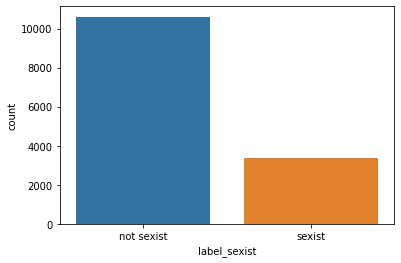

In [ ]:
# DATASET FOR SUB-TASK A

# Retain the unecessary columns 
sexism_dataset_task_a = sexism_dataset[['rewire_id','text','label_sexist']]

# Get the class distribution
countplot_sexism = sns.countplot(x = sexism_dataset_task_a.label_sexist)
print(sexism_dataset_task_a.label_sexist.value_counts())

# Rename the label column 
sexism_dataset_task_a = sexism_dataset_task_a.rename({'label_sexist':'label'}, axis = 1)

# Replace the categorical values with numeral values for training 
sexism_dataset_task_a.label.replace(labels_to_id_task_a, inplace = True)

In [ ]:
sexism_dataset_task_a[sexism_dataset_task_a.label == 1].head(20)

,rewire_id,text,label
8,sexism2022_english-10142,"just the inside of your wallet: cash, bank car...",1
11,sexism2022_english-760,They get the initial chance because they are a...,1
17,sexism2022_english-1108,ugly chicks A pussy is a pussy.,1
18,sexism2022_english-10099,fuck her off with a nine mm this is what you g...,1
19,sexism2022_english-10014,How about I talk shit to an idiot like you? Ar...,1
21,sexism2022_english-10606,If you want to attack culture and norms you ha...,1
24,sexism2022_english-16370,"Nah, black women still get more replies on tin...",1
25,sexism2022_english-4429,dumb ass women today ask more why you are not ...,1
32,sexism2022_english-18545,Men can be whores also.,1
33,sexism2022_english-11481,Husbands. Kill your piece of shit commie wives,1


1    1590
2    1165
3     333
0     310
Name: label_category, dtype: int64


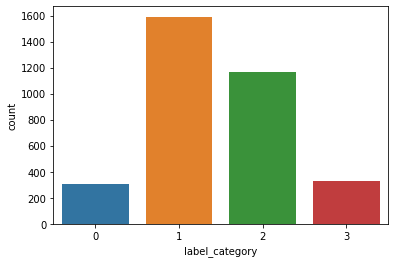

In [ ]:
# DATASET FOR SUB-TASK B

# Retain the unecessary columns 
sexism_dataset_task_b = sexism_dataset[['rewire_id','text','label_category']]

# Get all the texts with labels for task B except those that have 'none' 
sexism_dataset_task_b = sexism_dataset_task_b.loc[sexism_dataset_task_b['label_category'] != 'none']

# Replace the categorical values with numeral values for training 
sexism_dataset_task_b.label_category.replace(labels_to_id_task_b, inplace = True)

# Get the class distribution
countplot_sexism_b = sns.countplot(x = sexism_dataset_task_b.label_category)
print(sexism_dataset_task_b.label_category.value_counts())

# Rename the label column 
sexism_dataset_task_b = sexism_dataset_task_b.rename({'label_category':'label'}, axis = 1)

Distribution of data in classes after resampling:
0    1590
1    1590
2    1590
3    1590
Name: label, dtype: int64


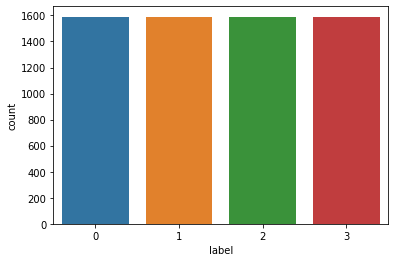

In [ ]:
# Separate the different labels and create a combined dataset
class_0 = sexism_dataset_task_b[sexism_dataset_task_b['label'] == 0]
class_1 = sexism_dataset_task_b[sexism_dataset_task_b['label'] == 1]
class_2 = sexism_dataset_task_b[sexism_dataset_task_b['label'] == 2]
class_3 = sexism_dataset_task_b[sexism_dataset_task_b['label'] == 3]

# Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
train_minority_upsampled_0 = resample(class_0, replace=True, n_samples=len(class_1),random_state=123)
train_minority_upsampled_2 = resample(class_2, replace=True, n_samples=len(class_1),random_state=123)
train_minority_upsampled_3 = resample(class_3, replace=True, n_samples=len(class_1),random_state=123) 

# Combine in a new dataframe the new resampled classes 
upsampled_dataset_task_b = pd.concat([train_minority_upsampled_0, class_1, train_minority_upsampled_2, train_minority_upsampled_3]) 
print('Distribution of data in classes after resampling:')
print(upsampled_dataset_task_b.label.value_counts())
countplot_upsampled_dataset_task_b = sns.countplot(x = upsampled_dataset_task_b.label)

2     717
3     673
5     637
6     417
10    258
1     254
4     200
9      75
7      64
0      56
8      47
Name: label_vector, dtype: int64


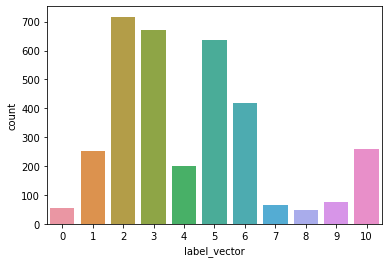

In [ ]:
# DATASET FOR SUB-TASK C

# Retain the unecessary columns 
sexism_dataset_task_c = sexism_dataset[['rewire_id','text','label_vector']]

# Get all the texts with labels for task B except those that have 'none' 
sexism_dataset_task_c = sexism_dataset_task_c.loc[sexism_dataset_task_c['label_vector'] != 'none']

# Replace the categorical values with numeral values for training 
sexism_dataset_task_c.label_vector.replace(labels_to_id_task_c, inplace = True)

# Get the class distribution
countplot_sexism_c = sns.countplot(x = sexism_dataset_task_c.label_vector)
print(sexism_dataset_task_c.label_vector.value_counts())

# Rename the label column 
sexism_dataset_task_c = sexism_dataset_task_c.rename({'label_vector':'label'}, axis = 1)

Distribution of data in classes after resampling:
2     717
8     717
3     673
5     637
6     417
10    258
0     254
1     254
7     254
9     254
4     200
Name: label, dtype: int64


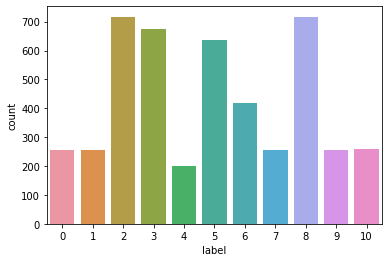

In [ ]:
# Separate the different labels and create a combined dataset
class_0 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 0]
class_1 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 1]
class_2 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 2]
class_3 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 3]
class_4 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 4]
class_5 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 5]
class_6 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 6]
class_7 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 7]
class_8 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 8]
class_9 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 9]
class_10 = sexism_dataset_task_c[sexism_dataset_task_c['label'] == 10]

# Upsampling: take samples with replacement from the minority class until the class is almost the same size as the majorities
train_minority_upsampled_0 = resample(class_0, replace =True, n_samples=len(class_1),random_state = 123)

#train_minority_upsampled_1 = resample(class_1, replace =True, n_samples=len(class_majorities),random_state = 123)
#train_minority_upsampled_2 = resample(class_2, replace =True, n_samples=len(class_1),random_state=123)
#train_minority_upsampled_3 = resample(class_3, replace =True, n_samples=len(class_2),random_state = 123)
#train_minority_upsampled_4 = resample(class_4, replace= True, n_samples=len(class_majorities),random_state = 123) 
#train_minority_upsampled_5 = resample(class_5, replace =True, n_samples=len(class_majorities),random_state = 123) 
#train_minority_upsampled_6 = resample(class_6, replace =True, n_samples=len(class_majorities),random_state = 123) 

train_minority_upsampled_7 = resample(class_7, replace =True, n_samples=len(class_1),random_state = 123) 
train_minority_upsampled_8 = resample(class_8, replace =True, n_samples=len(class_2),random_state = 123) 
train_minority_upsampled_9 = resample(class_9, replace =True, n_samples=len(class_1),random_state = 123) 

#train_minority_upsampled_10 = resample(class_10, replace =True, n_samples=len(class_majorities),random_state = 123) 

# Combine in a new dataframe the new resampled classes 
upsampled_dataset_task_c = pd.concat([train_minority_upsampled_0, class_1, class_2, class_3, class_4, class_5, class_6, train_minority_upsampled_7, train_minority_upsampled_8, train_minority_upsampled_9, class_10]) 
print('Distribution of data in classes after resampling:')
print(upsampled_dataset_task_c.label.value_counts())
countplot_upsampled_dataset_task_c = sns.countplot(x = upsampled_dataset_task_c.label)

In [ ]:
sexist_dictionary = {'text':["Boys will be boys.", "She's asking for it dressed like that.", "Men will be men.", "My ex-girlfriend is crazy.", "She’s such a drama queen.", "She was hysterical.", "She was in hysterics.", "She was crying hysterically.", "She is a feisty woman.", "That's what you get for being a single career woman, girl.", 
                             "She is a working mother.", "Her bubbly personality's just perfect for a salesperson.", "Always a bridesmaid, never a bride.", "Man up!", "She was asking for it.", "Fight like a girl.", "What were you wearing?", "Don't worry your pretty little head.", "She's just mad because it's her time of the month.", "She is a bossy and demanding woman, fond of having affairs with much younger men.", 
                             "She had perky tits and the best ass.", "Because my sister is a shrew with a disagreeable personality, she’ll probably never get married.", "Damn... Man, did you see the tits and ass on that chick? Man she's built like a thoroughbred!", "She is so frigid!", "Tell his ditzy wife that if she won't do anything to keep the bastard away, we sure can't.", "She is a hussy.", "Why don't you go and clean something?","He has soft hands like a woman.", "She always wears the most mannish outfits.", "Her catty remarks", 
                             "She is an ice queen.", "She is such a bitch!", "She is such a slut!", "You are a pussy!", "You are acting like a pussy.", "My neighbour is a complete bitch.", "Women are bitches", "She is with him only because he has a fortune. Such a golddigger!", 
                             "She is just a housewife.", "She always agrues with people. She is a fishwife.", "Every man for himself", "No man is an island", "Give a man a fish, and you’ll feed him for a day", "A dog is a man’s best friend", "Every man and his dog", "She acted like a spoilt diva demanding to be the centre of attention and her foul mouth was far from ladylike.", "The director accused her of being a selfish prima donna who was impossible to work with.", 
                             "She is so dumb. She is a silly blonde after all.", "She is such an easy woman to get into bed.", "She looks like a trollop in that skimpy outfit!", "She has a reputation for being a frigid woman.", "He is such a prude that he won't even swear.", "She always wears so slutty clothes!", "She is a slutty woman", "I can't believe she is gay!", "Too bad that she is a lesbian!", "She is not only Muslim, but also a lesbian! It can't get any worse!", 
                             "Some people used to consider smoking and drinking not to be ladylike.", "He has a vivacious personality and is full of energy.", "The boy is quite demure when grown-ups are around.", "She always wore very modest clothing.", "Go back into your kitchen, woman!", "That’s good, for a girl.", "Like a girl", "Mumpreneur", "She will become a spinster, if she doesn't find a husband soon.", "She can't bear him any children. She is a barren.", 
                             "She wears the pants.", "She is nothing more than his mistress", "She is his kept woman", "The women always find an excuse for a catfight.", "She was a tomboy when she was a child, and preferred playing basketball over playing with dolls.", "Grow a pair of balls.", "There is no place for black lesbian women here!"
                             "Don't be a sissy!", "Sow your wild oats", "Get your knickers in a twist", "Don't be a pussy.", "She is crazy.", "Grow a pair!",
                             "You’re a girl, you should know better.", "Sit like a lady.", "Good girl.", "Don't cry like a girl.", "Who wears the pants in this relationship?", "For a woman, you're a great negotiator.", "Why would you want to wash clothes, you're a man!", "Why would you want to cook, you're a man!",
                             "My dad doesn't do household chores, that's my mother's job!", "She always hangs around with boys. She is 'THAT' kind of girl.", "You're a woman - you cannot be loud.","'SIT' properly. You should be shy and demure, like a doll.", "You're a woman! Don't be so aggressive. And if you talk too loudly, who will marry you?", "It's not nice for a woman to laugh so loudly.", "If she is a 'career' woman, she can't be a good 'mother'.", "Boys don't get raped.", "Don't act like a girl.", "Don't be gay.", "Be a man! Act tough!",
                             "Stop crying like a girl.", "You wear shorts and go out? You're inviting rape.", "He couldn't stand Margaret when she was in one of her perky moods."],
                     'label':['sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist','sexist']}

In [ ]:
df_sexist_dict = pd.DataFrame(sexist_dictionary)

#df_sexist_dict.to_csv(args['train_data_directory'] + 'Sexist_dictionary.csv', encoding = 'utf-8', index = False, header = True, sep =',')

# Replace the categorical values with numeral values for training 
df_sexist_dict.label.replace(labels_to_id_task_a, inplace = True)

#df_sexist_dict.text = df_sexist_dict.text.apply(lambda x: preprocessing(x))
df_sexist_dict

,text,label
0,Boys will be boys.,1
1,She's asking for it dressed like that.,1
2,Men will be men.,1
3,My ex-girlfriend is crazy.,1
4,She’s such a drama queen.,1
...,...,...
96,Don't be gay.,1
97,Be a man! Act tough!,1
98,Stop crying like a girl.,1
99,You wear shorts and go out? You're inviting rape.,1


**PREPROCESSED EXAMPLES OF DATA**

In [ ]:
preprocessing("GREECE: Body of female dog that had been brutally raped to death found in a Muslimmmm migrantmigrant camp [URL] via [USER]")

'<allcaps> greece </allcaps> : body of female dog that had been brutally raped to death found in a muslimmmm migrantmigrant camp [ url ] via [ user ]'

In [ ]:
preprocessing("Captain of yacht Natalie Wood was on before she died says her husband Robert Wagner killed her | Daily Mail Online [URL]")

'captain of yacht natalie wood was on before she died says her husband robert wagner killed her | daily mail online [ url ]'

In [ ]:
preprocessing("Thatβ€™s because those women saying it donβ€™t seem to understand the difference between being an actual adult and a bitch. Some guys will call everyone a bitch when he doesn't get his way. r/NiceGuys is an")

'that trade marks because those women saying it don trade markt seem to understand the difference between being an actual adult and a bitch . some guys will call everyone a bitch when he does not get his way . r / niceguys is an'

**PRE-PROCESSING**

In [ ]:
#sexism_dataset_task_a.text = sexism_dataset_task_a.text.apply(lambda x: preprocessing(x))
#sexism_dataset_task_a.to_csv(args['train_data_directory'] + 'training_data_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')

#sexism_dataset_task_b.text = sexism_dataset_task_b.text.apply(lambda x: preprocessing(x))
#sexism_dataset_task_b.to_csv(args['train_data_directory'] + 'training_data_task_b.csv', encoding = 'utf-8', index = False, header = True, sep =',')

#sexism_dataset_task_c.text = sexism_dataset_task_c.text.apply(lambda x: preprocessing(x))
#sexism_dataset_task_c.to_csv(args['train_data_directory'] + 'training_data_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')

In [ ]:
#joined_dataset = pd.concat([sexism_dataset_task_a, df_sexist_dict], axis = 0)
#joined_dataset.drop('rewire_id', axis = 1, inplace = True) 
#joined_dataset.to_csv(args['train_data_directory'] + 'training_data_task_a_preprocessed.csv', encoding = 'utf-8', index = False, header = True, sep =',')

In [ ]:
#upsampled_dataset_task_b.text = upsampled_dataset_task_b.text.apply(lambda x: preprocessing(x))
#upsampled_dataset_task_b.to_csv(args['train_data_directory'] + 'training_data_balanced_task_b.csv', encoding = 'utf-8', index = False, header = True, sep =',')
#upsampled_dataset_task_c.text = upsampled_dataset_task_c.text.apply(lambda x: preprocessing(x))
#upsampled_dataset_task_c.to_csv(args['train_data_directory'] + 'training_data_balanced1_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')

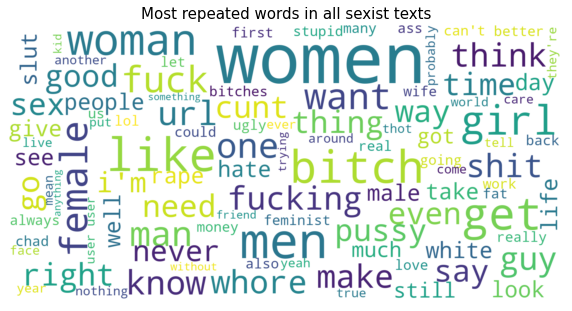

In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['u', 'wa', 'ha', 'would', 'com'])

# Get a string of the fake news text only
text_sexist_task_a = ",".join(txt.lower() for txt in sexism_dataset_task_a.text[sexism_dataset_task_a.label==1])

# Create and generate a word cloud image:
wordcloud = WordCloud(max_font_size=50, 
                      max_words=100,
                      stopwords=stop_words,
                      scale=5,
                      background_color="white").generate(text_sexist_task_a)

# Display the generated image:
plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Most repeated words in all sexist texts',fontsize=15)
plt.show()

**OPEN THE TRAINING SET** 

In [ ]:
# Uncomment the training set depending on the sub-task and comment the rest
# Sub-task A
sexism_training_task_a = read_a_file(args['train_data_directory'] + 'training_data_task_a_preprocessed.csv')

# Sub-task B
sexism_training_task_b = read_a_file(args['train_data_directory'] + 'training_data_task_b.csv')

# Sub-task C
sexism_training_task_c = read_a_file(args['train_data_directory'] + 'training_data_task_c.csv') 

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/training_data_task_c.csv']
rewire_id                      3398
text                           3398
label                            11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3398 entries, 0 to 3397
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  3398 non-null   object
 1   text       3398 non-null   object
 2   label      3398 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 79.8+ KB
Maximum sentence length:  96
Minimum sentence length:  5


**LOAD AND PREPARE THE DEVELOPMENT DATASETS**

In [ ]:
# TASK A
# Open and read the development set with the unlabelled texts
dev_set_task_a = read_a_file(args['train_data_directory'] + 'dev_task_a_entries.csv', labelled_dataset = True)

# Apply preprocessing steps on the texts
dev_set_task_a.text = dev_set_task_a.text.apply(lambda x: preprocessing(x))

# Open and read the development set with the labels
labels_task_a = read_a_file(args['train_data_directory'] + 'dev_task_a_labels.csv', labelled_dataset = False)

# Join texts with their corresponding labels
dev_set_task_a_labeled = pd.concat([dev_set_task_a, labels_task_a.label], axis = 1)

dev_set_task_a_labeled.label.replace(labels_to_id_task_a, inplace = True)

# Save joined file in csv 
#dev_set_task_a_labeled.to_csv(args['train_data_directory'] + 'dev_set_task_a_preprocessed_labelled.csv', encoding = 'utf-8', index = False, header = True, sep =',')

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_a_entries.csv']
rewire_id                      2000
text                           2000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  2000 non-null   object
 1   text       2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB
Maximum sentence length:  93
Minimum sentence length:  4
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_a_labels.csv']
rewire_id                      2000
label                             2
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  2000 non-null   object
 1   label      2000 non-null 

In [ ]:
# TASK B
# Open and read the development set with the unlabelled texts
dev_set_task_b = read_a_file(args['train_data_directory'] + 'dev_task_b_entries.csv', labelled_dataset = True)

# Apply preprocessing steps on the texts
dev_set_task_b.text = dev_set_task_b.text.apply(lambda x: preprocessing(x))

# Open and read the development set with the labels
labels_task_b = read_a_file(args['train_data_directory'] + 'dev_task_b_labels.csv', labelled_dataset = False)

# Join texts with their corresponding labels
dev_set_task_b_labeled = pd.concat([dev_set_task_b, labels_task_b.label], axis = 1)

dev_set_task_b_labeled.label.replace(labels_to_id_task_b, inplace = True)

# Save joined file in csv 
#dev_set_task_b_labeled.to_csv(args['train_data_directory'] + 'dev_set_task_b_preprocessed_labelled.csv', encoding = 'utf-8', index = False, header = True, sep =',')

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_b_entries.csv']
rewire_id                       486
text                            486
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  486 non-null    object
 1   text       486 non-null    object
dtypes: object(2)
memory usage: 7.7+ KB
Maximum sentence length:  67
Minimum sentence length:  7
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_b_labels.csv']
rewire_id                       486
label                             4
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  486 non-null    object
 1   label      486 non-null    obj

In [ ]:
# TASK C
# Open and read the development set with the unlabelled texts
dev_set_task_c = read_a_file(args['train_data_directory'] + 'dev_task_c_entries.csv', labelled_dataset = True)

# Apply preprocessing steps on the texts
dev_set_task_c.text = dev_set_task_c.text.apply(lambda x: preprocessing(x))

# Open and read the development set with the labels
labels_task_c = read_a_file(args['train_data_directory'] + 'dev_task_c_labels.csv', labelled_dataset = False)

# Join texts with their corresponding labels
dev_set_task_c_labeled = pd.concat([dev_set_task_c, labels_task_c.label], axis = 1)

dev_set_task_c_labeled.label.replace(labels_to_id_task_c, inplace = True)

# Save joined file in csv 
#dev_set_task_c_labeled.to_csv(args['train_data_directory'] + 'dev_set_task_c_preprocessed_labelled.csv', encoding = 'utf-8', index = False, header = True, sep =',')

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_c_entries.csv']
rewire_id                       486
text                            486
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  486 non-null    object
 1   text       486 non-null    object
dtypes: object(2)
memory usage: 7.7+ KB
Maximum sentence length:  67
Minimum sentence length:  7
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_task_c_labels.csv']
rewire_id                       486
label                            11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  486 non-null    object
 1   label      486 non-null    obj

**OPEN THE DEVELOPMENT SET**

In [ ]:
# Incomment depending on the sub-task and comment the rest
sexism_dev_task_a = read_a_file(args['train_data_directory'] + 'dev_set_task_a_preprocessed_labelled.csv')
sexism_dev_task_b = read_a_file(args['train_data_directory'] + 'dev_set_task_b_preprocessed_labelled.csv')
sexism_dev_task_c = read_a_file(args['train_data_directory'] + 'dev_set_task_c_preprocessed_labelled.csv', labelled_dataset = True)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/dev_set_task_c_preprocessed_labelled.csv']
rewire_id                       486
text                            486
label                            11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  486 non-null    object
 1   text       486 non-null    object
 2   label      486 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 11.5+ KB
Maximum sentence length:  75
Minimum sentence length:  7


In [ ]:
# Open the labelled file with all splits provided after the end of the competition
sexism_test_set_labelled_all = read_a_file(args['train_data_directory'] + 'edos_labelled_aggregated.csv')

# Get only the test texts
sexism_test_set_labelled_test = sexism_test_set_labelled_all.loc[sexism_test_set_labelled_all['split'] == 'test']

# Apply pre-processing steps to the test sets
sexism_test_set_labelled_test.text = sexism_test_set_labelled_test.text.apply(lambda x: preprocessing(x))

# Retain the unecessary columns for sub-task A
sexism_test_set_labelled_test_task_a = sexism_test_set_labelled_test[['rewire_id','text','label_sexist']]
# Rename the label column 
sexism_test_set_labelled_test_task_a = sexism_test_set_labelled_test_task_a.rename({'label_sexist':'label'}, axis = 1)
# Replace the categorical values with numeral values for training 
sexism_test_set_labelled_test_task_a.label.replace(labels_to_id_task_a, inplace = True)

# Retain the unecessary columns for sub-task B
sexism_test_set_labelled_test_task_b = sexism_test_set_labelled_test[['rewire_id','text','label_category']]
sexism_test_set_labelled_test_task_b = sexism_test_set_labelled_test_task_b.loc[sexism_test_set_labelled_test_task_b['label_category'] != 'none']
# Rename the label column 
sexism_test_set_labelled_test_task_b = sexism_test_set_labelled_test_task_b.rename({'label_category':'label'}, axis = 1)
# Replace the categorical values with numeral values for training 
sexism_test_set_labelled_test_task_b.label.replace(labels_to_id_task_b, inplace = True)

# Retain the unecessary columns for sub-task C
sexism_test_set_labelled_test_task_c = sexism_test_set_labelled_test[['rewire_id','text','label_vector']]
sexism_test_set_labelled_test_task_c = sexism_test_set_labelled_test_task_c.loc[sexism_test_set_labelled_test_task_c['label_vector'] != 'none']
# Rename the label column 
sexism_test_set_labelled_test_task_c = sexism_test_set_labelled_test_task_c.rename({'label_vector':'label'}, axis = 1)
# Replace the categorical values with numeral values for training 
sexism_test_set_labelled_test_task_c.label.replace(labels_to_id_task_c, inplace = True)

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/train_dev_data/edos_labelled_aggregated.csv']
rewire_id                     20000
text                          20000
label_sexist                      2
label_category                    5
label_vector                     12
split                             3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   rewire_id       20000 non-null  object
 1   text            20000 non-null  object
 2   label_sexist    20000 non-null  object
 3   label_category  20000 non-null  object
 4   label_vector    20000 non-null  object
 5   split           20000 non-null  object
dtypes: object(6)
memory usage: 937.6+ KB
Maximum sentence length:  374
Minimum sentence length:  4


/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


**SPLIT INTO TRAIN AND VALIDATIONS SETS & CREATE TRAIN AND VALIDATION/DEVELOPMENT DATALOADERS**

In [ ]:
# Replace the names of the dataframes based on the sub-task 
train_dataloader, val_dataloader = TextSplitDataPreparation(dataframe_1 = sexism_training_task_c, # sexism_training_task_a, sexism_training_task_b, sexism_training_task_c
                                                            dataframe_2 = sexism_dev_task_c, # sexism_dev_task_a, sexism_dev_task_b, sexism_dev_task_c
                                                            split_ratio = args['data_split_ratio'], 
                                                            tokenizer = tokenizer, 
                                                            max_length = args['max_seq_length'], 
                                                            batch_size = args['batch_size'], 
                                                            procedure_1 = False,
                                                            split_data = False, 
                                                            make_dataloaders = False)

The train and validation dataloaders are ready for training and evaluation.


**CALCULATE THE WEIGHTS FOR EACH CLASS DUE TO DATA IMBALANCE**

In [ ]:
# Uncomment the weights depending on the sub-task
#weights_classes = compute_class_weights(sexism_training_task_a.label)
#weights_classes = compute_class_weights(sexism_training_task_b.label)
weights_classes = compute_class_weights(sexism_training_task_c.label)

weights_classes = torch.tensor(weights_classes,dtype=torch.float)
weights_classes = weights_classes.to(device)

[5.51623377 1.21617752 0.43083555 0.45900311 1.54454545 0.48494363
 0.74078919 4.82670455 6.57253385 4.11878788 1.19732206]


**INSTANTIATE MODELS**

In [ ]:
class CLASSIFIER_LAST_HIDDEN_STATE(nn.Module):
    
  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_bert = False):
    super(CLASSIFIER_LAST_HIDDEN_STATE, self).__init__()
    
    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes  
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(self.hidden_size, self.num_classes)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, return_dict = False)
    
    # Get the last hidden state   
    last_hidden_state = outputs[0]
    
    # Extract the last hidden state of the token `[CLS]` for the classification task
    cls_embeddings = last_hidden_state[:, 0]

    # Apply dropout
    dropout_output = self.dropout(cls_embeddings)
     
    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)

    final_output = self.softmax(final_output)
    
    #Last Hidden State Output Shape: [batch size, max seq len, hidden size]
    #CLS Embeddings Output Shape: [batch size, hidden size]
    #Final output Shape: [batch size, number of classes]

    return final_output  

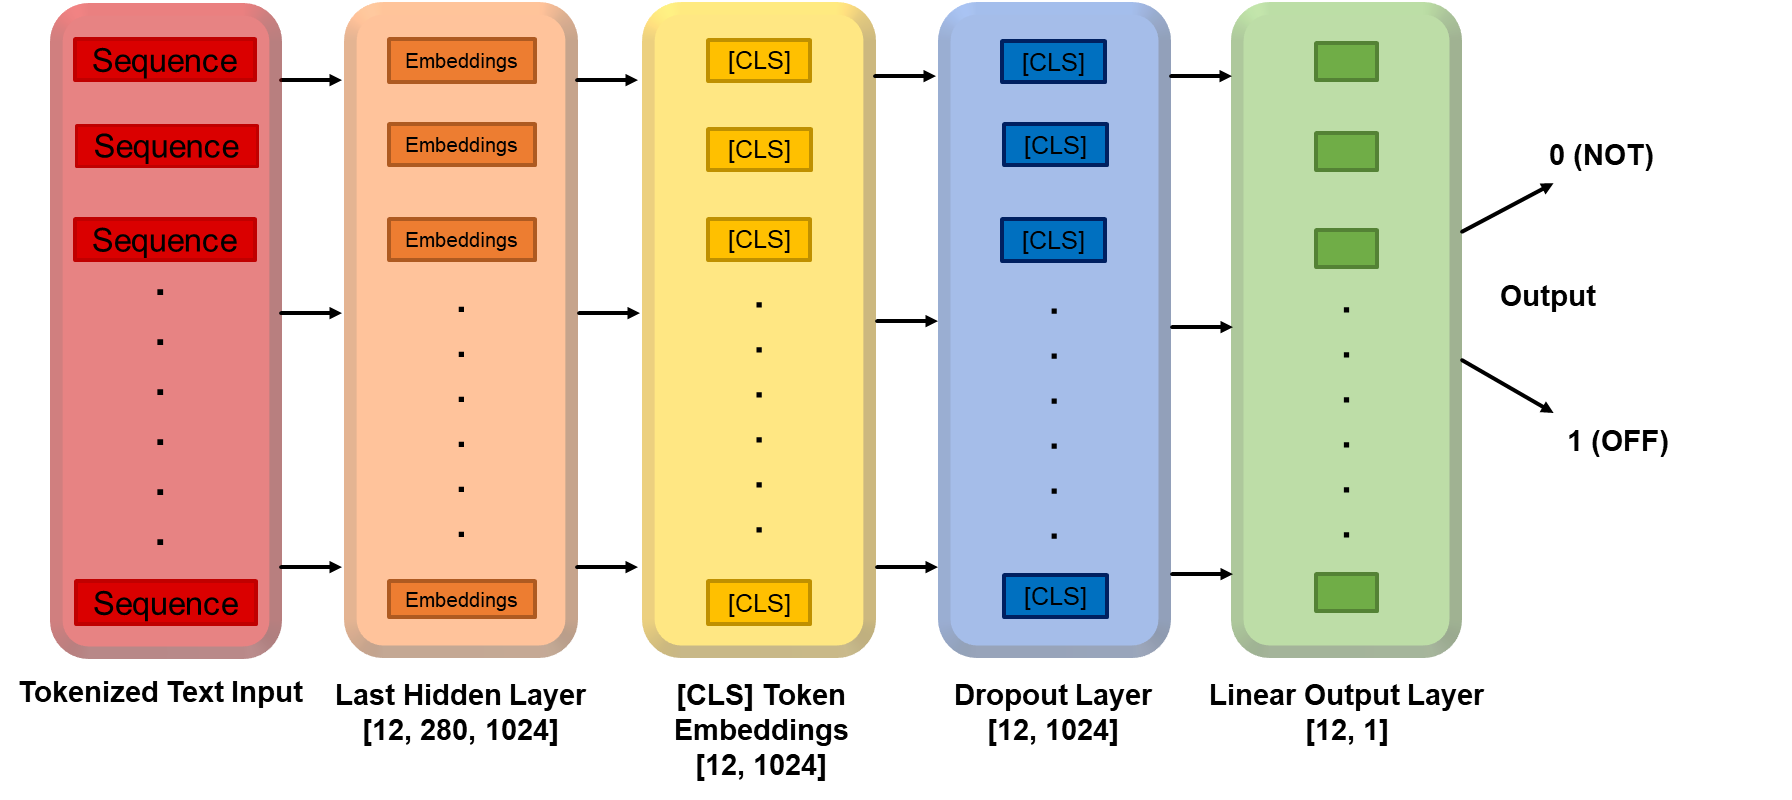

In [ ]:
class CLASSIFIER_CONCAT_LAST_4_HIDDEN_STATES(nn.Module):
    
  def __init__(self, pretrained_model, num_classes, config, dropout, freeze_bert = False):
    super(CLASSIFIER_CONCAT_LAST_4_HIDDEN_STATES, self).__init__()
    
    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes  
    self.dropout = nn.Dropout(dropout)
    self.classifier = nn.Linear(self.hidden_size * 4, self.num_classes)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
    
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask, return_dict = False)
    
    # Concatenate the 4 last hidden layers and get the [CLS] token
    all_hidden_states = torch.stack(outputs[2])   
    concatenate_pooling = torch.cat((all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]), dim = -1)
    last_hidden_state_cls = concatenate_pooling[:, 0]
 
    # Apply dropout
    dropout_output = self.dropout(last_hidden_state_cls)

    # Feed input to classifier to compute logits
    final_output = self.classifier(dropout_output)
    final_output = self.softmax(final_output)

    #print(f'Hidden States Output Shape: {all_hidden_states.shape}') # [initial embeddings + 24 BERT layers, batch size, max seq len, hidden size]
    #print(f'Concatenate Pooling  Output Shape: {concatenate_pooling.shape}') # [batch size, max seq len, hidden size * 4]
    #print(f'CLS Output Shape: {last_hidden_state_cls.shape}') # [batch size, hidden size * 4]
    #print(f'Dropout Output Shape: {dropout_output.shape}') # [batch size, hidden size * 4]
    #print(f'Logits Shape: {final_output.shape}') # [batch size, num of classes]

    return final_output 

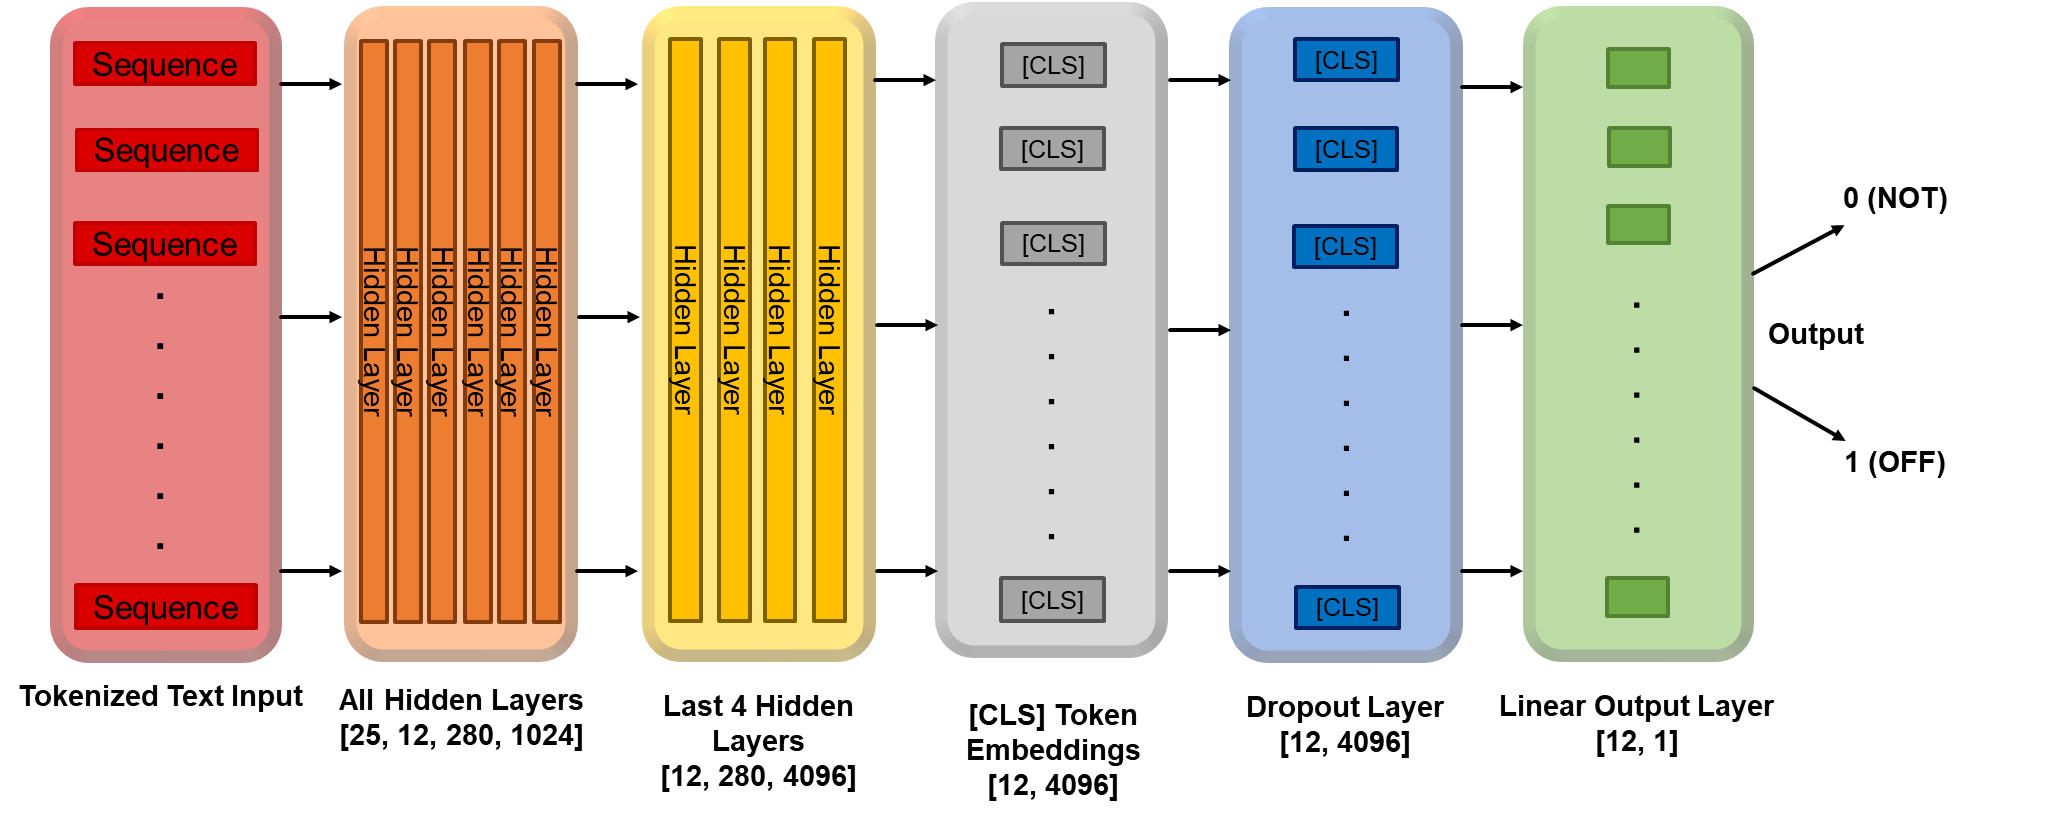

In [ ]:
class BIDIRECTIONAL_RNN_LSTM_GRU(nn.Module):
  
  def __init__(self, cell_type, pretrained_model, config, num_classes, dropout, num_layers, seq_len, bidirectional, freeze_bert = False):             
    super(BIDIRECTIONAL_RNN_LSTM_GRU, self).__init__()

    cells = {'LSTM': nn.LSTM, 'GRU': nn.GRU}   

    # Initializations
    self.cell_type = cell_type
    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_layers = num_layers
    self.num_classes = num_classes
    self.dropout = dropout
    self.sequence_length = seq_len
    self.softmax = torch.nn.Softmax(dim=-1)
     
    assert cell_type in cells, 'Use one of the following: {}'.format(str(cells))
    rnn_cell = getattr(nn, cell_type)          # It fetches the constructor from torch.nn
    self.rnn = rnn_cell(
        input_size = self.hidden_size,      # Number of features for each time step        
        num_layers = self.num_layers,          # If the number of layers is bigger than 1, then it is a stacked RNN)
        hidden_size = self.sequence_length,    # Use the selected maximum sequence length needed in Bert
        batch_first = True,                    # Input and output's batch size: (batch, time_step, input_size) => 1st dimension
        bidirectional = bidirectional)        # It is a bidirectional Recurrent Neural Network (RNN)
        #dropout = self.dropout)                # Dropout regularization  
                              
    # Final hidden state has both a forward and a backward component concatenated together
    # The size of the input to the nn.Linear layer is twice that of the hidden dimension size because it is bidirectional
    if bidirectional == True:
      self.classifier = nn.Linear(self.sequence_length * 2, self.num_classes)
    else:
      self.classifier = nn.Linear(self.sequence_length, self.num_classes)
    
    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)
  
    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False
  
  def forward(self, input_ids, attention_mask):
  
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)

    all_hidden_states = torch.stack(outputs[2])
    
    hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze() for layer_i in range(1, config.num_hidden_layers+1)], dim=-1)
    hidden_states = hidden_states.view(-1, config.num_hidden_layers, self.hidden_size)
    
    if self.cell_type == 'LSTM':
      packed_output, _ = self.rnn(hidden_states, None) 
    if self.cell_type == 'GRU':
      packed_output, _ = self.rnn(hidden_states, None)

    dropout_output = self.dropout(packed_output[:, -1, :])
    
    final_output = self.classifier(dropout_output)
    final_output = self.softmax(final_output)

    #print(f'All Hidden States Output Shape: {all_hidden_states.shape}') # [initial embeddings + 24 BERT layers, batch size, max seq len, hidden size]
    #print(f'Hidden States Output Shape: {hidden_states.shape}') # [batch size, 24 BERT layers, hidden size]
    #print(f'Packed Output Shape: {packed_output.shape}') # [batch size, 24 BERT layers, max seq len * 2]
    #print(f'LSTM Pooling Output Shape: {dropout_output.shape}') # [batch size, max seq len * 2]
    #print(f'Logits Shape: {final_output.shape}') # [batch size, output label shape]

    return final_output   

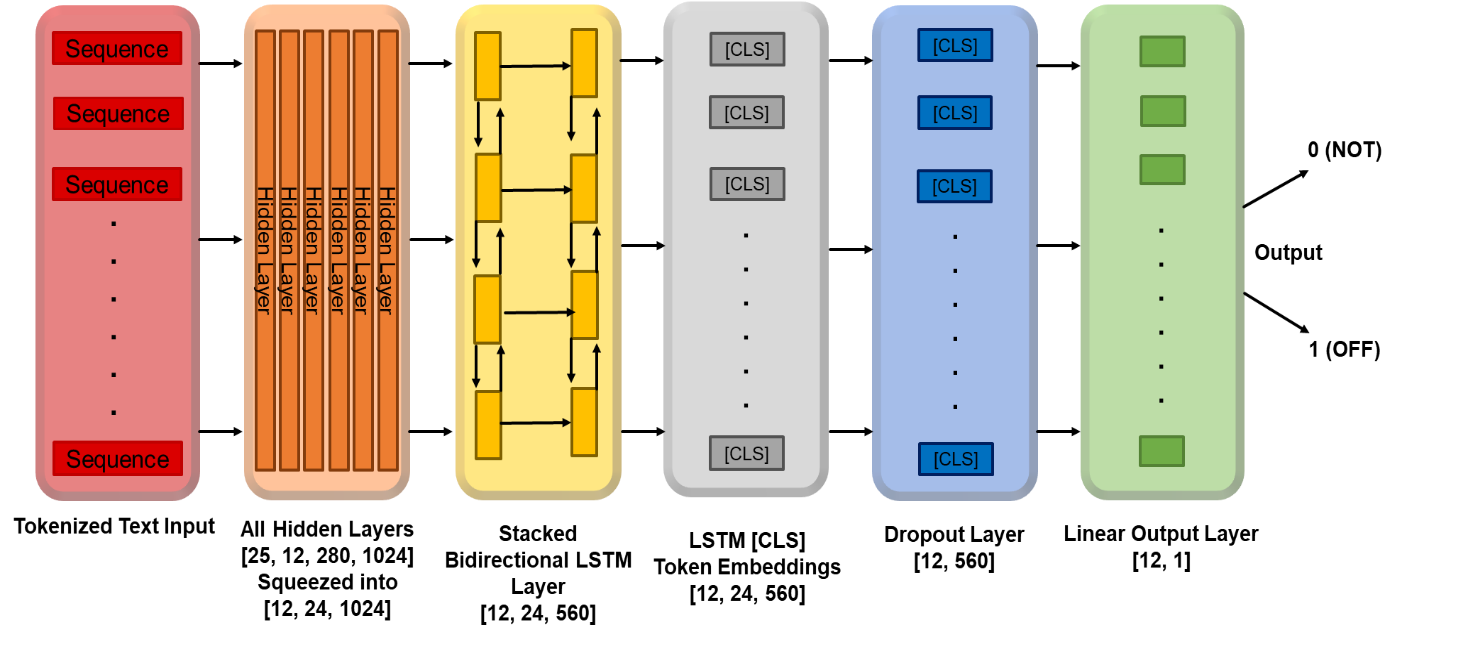

In [ ]:
class CLASSIFIER_WEIGHTED_LAYER_POOLING(nn.Module):
  
  def __init__(self, pretrained_model, config, num_classes, dropout, layer_start, layer_weights = None, freeze_bert = False):             
    super(CLASSIFIER_WEIGHTED_LAYER_POOLING, self).__init__()

    # Initializations
    self.pretrained_model = pretrained_model
    self.hidden_size = config.hidden_size
    self.num_classes = num_classes
    self.dropout = dropout 
    self.layer_start = layer_start
    self.num_hidden_layers = config.num_hidden_layers
    self.layer_weights = layer_weights if layer_weights is not None  else nn.Parameter(torch.tensor([1] * (self.num_hidden_layers+1 - layer_start), dtype=torch.float))
    self.classifier = nn.Linear(self.hidden_size, self.num_classes)
    self.softmax = torch.nn.Softmax(dim=-1)

    # Initialize dropout layer for regularization
    self.dropout = nn.Dropout(dropout)
  
    # Add possibility to freeze the BERT model to avoid fine tuning BERT params (usually leads to worse results)
    if freeze_bert:
      for param in self.pretrained_model.parameters():
        param.requires_grad = False

  def forward(self, input_ids, attention_mask):
 
    outputs = self.pretrained_model(input_ids = input_ids, attention_mask = attention_mask)
    all_hidden_states = torch.stack(outputs[2])

    all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
    weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
    weighted_average = (weight_factor * all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
    
    weighted_pooling_embeddings = weighted_average[:, 0]

    dropout_output = self.dropout(weighted_pooling_embeddings)

    final_output = self.classifier(dropout_output)

    final_output = self.softmax(final_output)

    #print(f'Hidden State Output Shape: {all_hidden_states.shape}') # [num of layers, batch size, sequence length, hidden size]
    #print(f'Weighted [CLS] Pooling Embeddings Output Shape: {weighted_pooling_embeddings.shape}') # [batch size, hidden size]
    #print(f'Logits Shape: {final_output.shape}') # [batch size, output label shape]

    return final_output 

**INITIALIZE MODEL & ITS HYPERPARAMETERS**

In [ ]:
# Uncomment the model you want to use

# Initialize the Classifier with only the last hidden state
model = CLASSIFIER_LAST_HIDDEN_STATE(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_bert = False)

# Initialize the Classifier by concatenating the last 4 hidden states
#model = CLASSIFIER_CONCAT_LAST_4_HIDDEN_STATES(pretrained_model = the_pretrained_model, num_classes = args['num_classes'], config = config, dropout = args['dropout'], freeze_bert = False)

# Initialize the Classifier by summing the last 4 hidden states                                                                                                      # 12
#model = CLASSIFIER_WEIGHTED_LAYER_POOLING(pretrained_model = the_pretrained_model, config = config, num_classes = args['num_classes'], dropout = args['dropout'], layer_start = 24, layer_weights = None, freeze_bert = False)

# Initialize the BERT Bi-Stacked-LSTM model 
#model = BIDIRECTIONAL_RNN_LSTM_GRU(cell_type = args['cell_type'], pretrained_model = the_pretrained_model, config = config, num_classes = args['num_classes'], dropout = args['dropout'], num_layers = args['num_layers'], seq_len = args['max_seq_length'], bidirectional = True, freeze_bert = False)

model.to(device)

# Total number of training steps
num_train_steps = int(len(train_dataloader) * args['num_train_epochs'])

# Define the optimizer and its parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}]

optimizer = torch.optim.AdamW(optimizer_grouped_parameters, lr = args['learning_rate'], eps = args['adam_epsilon'], betas=(0.9, 0.999))

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = args['warmup_steps'], num_training_steps = num_train_steps)

#pos_weight = torch.ones([1]).to(device)

# Loss functions
#def loss_function(outputs, targets):
#  return nn.BCEWithLogitsLoss(pos_weight=pos_weight)(outputs, targets.view(-1, 1)).to(device) 

def NLLloss(class_wts):
  weights = torch.tensor(class_wts,dtype=torch.float)
  weights = weights.to(device)
  return nn.NLLLoss(weight = weights)

def CrossEntropy(class_wts): 
  weights = torch.tensor(class_wts,dtype=torch.float)
  weights = weights.to(device)
  return nn.CrossEntropyLoss(weight = weights) 

#loss_function = CrossEntropy(weights_classes).to(device)
#loss_function = NLLloss(weights_classes).to(device)

loss_function = FocalLoss(gamma = 2, weights = weights_classes)

<ipython-input-46-684564b4e752>:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = torch.tensor(class_wts,dtype=torch.float)


**TRAIN AND EVALUATE BERT MODEL (TRAIN & VALIDATION SETS)**

In [ ]:
print('TRAINING PARAMETERS:\n')
print('Model Name: {}'.format(str(args['model_name'])))
print('The model has {:,} trainable parameters'.format(count_parameters(model)))
print('Loss function used: Binary Cross-Entropy Loss with Logits for sub-task A and Cross-Entropy Loss for sub-tasks B and C')
print('Optimizer used: AdamW')
print('Learning Rate: {:.5f}'.format(args['learning_rate']))
print('Adam Epsilon: {}'.format(args['adam_epsilon']))
print('Betas: {}'.format('0.9, 0.999'))
print('Weight Decay: {}'.format(args['weight_decay']))
print('Batch Size: {}'.format(args['batch_size']))
print('Number of training epochs: {}'.format(args['num_train_epochs']))
print('Maximum Sequence Length: {}'.format(args['max_seq_length']))
print('Bidirectional RNN Cell type: {}'.format(args['cell_type']))
print('Number of layers in the Bidirectional RNN: {}'.format(args['num_layers']))
print('Warm-up Steps: {}'.format(args['warmup_steps']))
print('Max grad Norm: {}'.format(args['max_grad_norm']))
print('Number of training steps: {}'.format(num_train_steps))
print('Dropout: {}'.format(args['dropout']))

TRAINING PARAMETERS:

Model Name: roberta-large
The model has 359,577,149 trainable parameters
Loss function used: Binary Cross-Entropy Loss with Logits for sub-task A and Cross-Entropy Loss for sub-tasks B and C
Optimizer used: AdamW
Learning Rate: 0.00002
Adam Epsilon: 1e-08
Betas: 0.9, 0.999
Weight Decay: 0.01
Batch Size: 16
Number of training epochs: 6
Maximum Sequence Length: 375
Bidirectional RNN Cell type: LSTM
Number of layers in the Bidirectional RNN: 1
Warm-up Steps: 0.06
Max grad Norm: 1.0
Number of training steps: 1278
Dropout: 0.1


In [ ]:
print('Training model in {} sentences and evaluating model in {} sentences...'.format(len(train_dataloader), len(val_dataloader)))
# Store losses and accuracies
training_stats = []

# Define best_score, counter, and patience for early stopping:
best_score = None
counter = 0
patience = 5

# Measure the total training and evaluation time
total_t0 = time.time()

for epoch in range(0, args['num_train_epochs']):
  print('\n======== EPOCH {} / {} ========\n'.format(epoch + 1, args['num_train_epochs']))
  print('TRAINING MODEL...') 
    
  # Measure how long the training epoch takes
  t0 = time.time()

  training_loss = 0
  training_acc = 0  
    
  model.train()
    
  for step, batch in enumerate(tqdm(train_dataloader, desc = 'Training iteration')):

    # Progress update every 1000 batches  
    if step % 1000 == 0 and not step == 0:  
        
      # Calculate elapsed time in minutes
      elapsed = calculate_time(time.time() - t0)
              
      # Report progress
      print(f' Batch {step} of {len(train_dataloader)} | Elapsed time: {elapsed}') 
      
    input_ids = batch['input_ids'].to(device)   
    attention_masks = batch['attention_mask'].to(device) 
    labels = batch['label'].to(device)
     
    # Zero the gradients
    optimizer.zero_grad()
      
    # Perform forward propagation. Compute the predictions                            
    predictions = model(input_ids = input_ids, attention_mask = attention_masks)
                                                                       
    # Compute the loss  
    loss = loss_function(predictions, labels)
 
    # Move logits and labels to CPU
    predictions = predictions.detach().cpu().numpy()
    labels = labels.to('cpu').numpy()

    # Compute the accuracy
    acc = accuracy(predictions, labels)
    
    # Perform backward propagation
    loss.backward()

    # Clip the gradient value
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm = args['max_grad_norm']) # Avoid exploding of gradients
      
    # Use optimizer to take gradient step and Update the learning rate
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
                      
    training_loss += loss.item()
    training_acc += acc.item()

  train_loss_of_epoch = training_loss / len(train_dataloader)
  train_accuracy_of_epoch = training_acc / len(train_dataloader)
          
  # Measure the epoch training time
  training_time = calculate_time(time.time() - t0)
    
  print('Training epoch time: {} | Train Loss: {:.3f} | Train Acc: {:.2f}%'.format(training_time, train_loss_of_epoch, train_accuracy_of_epoch*100))
    
  print('\nEVALUATING MODEL...')
    
  t0 = time.time()

  model.eval()  

  eval_loss = 0
  eval_acc = 0
  
  # Calculation of gradient not required during evaluation 
  with torch.no_grad():  
    
    for batch in tqdm(val_dataloader, desc = 'Evaluation iteration'):
      ids_inputs = batch['input_ids'].to(device)
      att_masks = batch['attention_mask'].to(device)
      targets = batch['label'].to(device)
      
      # Perform forward propagation
      outputs = model(input_ids = ids_inputs, attention_mask = att_masks)
        
      # Compute the loss 
      logits = loss_function(outputs, targets)
  
      # Move logits and labels to CPU
      outputs = outputs.detach().cpu().numpy()
      targets = targets.to('cpu').numpy()

      # Compute the accuracy
      accur = accuracy(outputs, targets)
      
      eval_loss += logits.item()
      eval_acc += accur.item()

  loss_of_epoch_val = eval_loss / len(val_dataloader)
  accuracy_of_epoch_val = eval_acc / len(val_dataloader)

  # Measure the validating epoch time
  validation_time = calculate_time(time.time() - t0)

  print(f'Validation epoch time: {validation_time} | Validation Loss: {loss_of_epoch_val:.3f} | Validation Acc: {accuracy_of_epoch_val*100:.2f}%')
  
  if best_score is None:
    best_score = loss_of_epoch_val
  else:
    # Check if val_loss improves or not.
    if loss_of_epoch_val < best_score:
      # val_loss improves, we update the latest best_score, and save the current model
      best_score = loss_of_epoch_val
      #save_ckp(checkpoint, True, checkpoint_path, best_model_path)
      #save_model(model, model_filename, args['output_specific_model_dir'])  
    else:
      # val_loss does not improve, we increase the counter, stop training if it exceeds the amount of patience
      counter += 1
      if counter >= patience:
        print('EARLY STOPPING!')
        break

  # Record all statistics from each epoch
  training_stats.append({'Epoch': epoch + 1,
                         'Training Loss': train_loss_of_epoch,
                         'Validation Loss': loss_of_epoch_val,
                         'Training Accuracy': train_accuracy_of_epoch,
                         'Validation Accuracy': accuracy_of_epoch_val,
                         'Training Time': training_time,
                         'Validation Time': validation_time})
  
  #checkpoint = {'epoch': epoch + 1,
  #          'valid_loss_min': loss_of_epoch_val,
  #          'state_dict': model.state_dict(),
  #          'optimizer': optimizer.state_dict(),}
        
  # save checkpoint
  #save_ckp(checkpoint, False, checkpoint_path, best_model_path)
 
print('Training and evaluation process complete!')
print('Total amount of time: {}'.format(calculate_time(time.time()-total_t0)))

Training model in 213 sentences and evaluating model in 31 sentences...

======== EPOCH 1 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:07<00:00,  1.14it/s]


Training epoch time: 0:03:07 | Train Loss: 2.246 | Train Acc: 13.82%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.95it/s]


Validation epoch time: 0:00:08 | Validation Loss: 2.365 | Validation Acc: 3.83%

======== EPOCH 2 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Training epoch time: 0:03:07 | Train Loss: 1.889 | Train Acc: 32.93%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.94it/s]


Validation epoch time: 0:00:08 | Validation Loss: 2.328 | Validation Acc: 4.84%

======== EPOCH 3 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Training epoch time: 0:03:06 | Train Loss: 1.826 | Train Acc: 35.56%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.95it/s]


Validation epoch time: 0:00:08 | Validation Loss: 2.353 | Validation Acc: 5.98%

======== EPOCH 4 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Training epoch time: 0:03:07 | Train Loss: 1.765 | Train Acc: 44.56%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.94it/s]


Validation epoch time: 0:00:08 | Validation Loss: 2.298 | Validation Acc: 11.22%

======== EPOCH 5 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Training epoch time: 0:03:07 | Train Loss: 1.723 | Train Acc: 52.28%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.93it/s]


Validation epoch time: 0:00:08 | Validation Loss: 2.253 | Validation Acc: 14.85%

======== EPOCH 6 / 6 ========

TRAINING MODEL...


Training iteration: 100%|██████████| 213/213 [03:06<00:00,  1.14it/s]


Training epoch time: 0:03:07 | Train Loss: 1.692 | Train Acc: 57.48%

EVALUATING MODEL...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.95it/s]

Validation epoch time: 0:00:08 | Validation Loss: 2.239 | Validation Acc: 16.47%
Training and evaluation process complete!
Total amount of time: 0:19:27


**SAVE THE TRAINED MODEL**

In [ ]:
#save_model(model, 'Classifier_albert_LastHidden1_task_b.pt', args['output_specific_model_dir']) 

**VIEW THE RESULTS FROM TRAINING AND VALIDATION**

In [ ]:
# Display floats with two decimal places
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics
df_stats = pd.DataFrame(data = training_stats)

# Use the 'epoch' as the row index
df_stats = df_stats.set_index('Epoch')

# Display the table
df_stats

,Training Loss,Validation Loss,Training Accuracy,Validation Accuracy,Training Time,Validation Time
Epoch,,,,,,
1,2.25,2.36,0.14,0.04,0:03:07,0:00:08
2,1.89,2.33,0.33,0.05,0:03:07,0:00:08
3,1.83,2.35,0.36,0.06,0:03:06,0:00:08
4,1.77,2.30,0.45,0.11,0:03:07,0:00:08
5,1.72,2.25,0.52,0.15,0:03:07,0:00:08
6,1.69,2.24,0.57,0.16,0:03:07,0:00:08


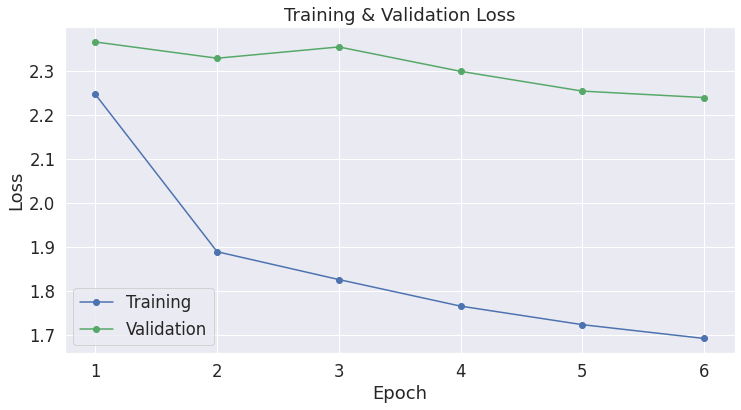

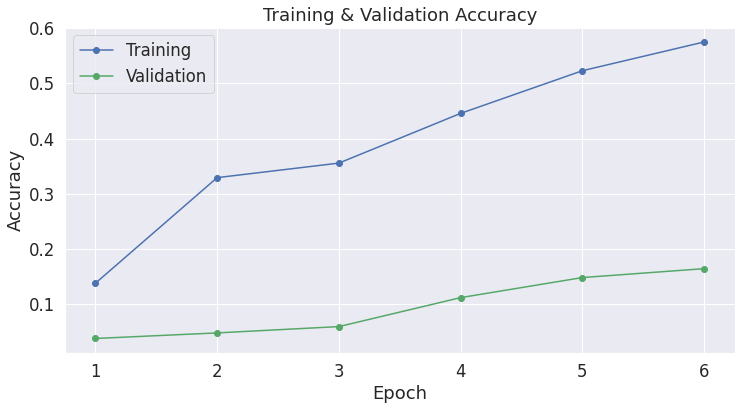

In [ ]:
# Use plot styling from seaborn
sns.set(style='darkgrid')

# Increase the plot size and font size
sns.set(font_scale=1.5)
plt.rcParams['figure.figsize'] = (12,6)

# Plot the learning curve of loss
plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Validation Loss'], 'g-o', label='Validation')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the learning curve of accuracy
plt.plot(df_stats['Training Accuracy'], 'b-o', label='Training')
plt.plot(df_stats['Validation Accuracy'], 'g-o', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
class Data_Preparation_Dev_Test(Dataset):
  
  def __init__(self, text, tokenizer, max_len):  
    self.text = text
    self.tokenizer = tokenizer
    self.max_len = max_len
        
  def __len__(self):  
    return len(self.text)

  def __getitem__(self, index): 

    text = str(self.text[index])
    text = " ".join(text.split())

    encoding = self.tokenizer.encode_plus(text = text,
                                          text_pair = None,
                                          add_special_tokens = True,      # Add [CLS] and [SEP]
                                          max_length = self.max_len,      # Max length to pad
                                          padding = 'max_length',         # Pad sentence according to max length  'max_length'
                                          truncation = True,              # Truncate the sentences
                                          return_token_type_ids = False,  # Do not return the ids of type tokens
                                          return_attention_mask = True,   # Return attention mask
                                          return_tensors = 'pt')          # Return PyTorch tensor
  
    return {'input_ids': encoding['input_ids'].flatten(),  
            'attention_mask': encoding['attention_mask'].flatten()}


def create_data_loader_test(df, tokenizer, max_len, batch_size, shuffle, sampler = 'test'):
  
  data = Data_Preparation_Dev_Test(text = df.text.to_numpy(),
                              tokenizer = tokenizer,
                              max_len = max_len)
  if sampler == 'test':
    sampler = SequentialSampler(data)
  else:
    sampler = None

  return DataLoader(data, batch_size = batch_size, pin_memory = True, sampler = sampler, shuffle = shuffle)


# A function that evaluates a trained model on a unlabelled development/test set
def evaluate_no_labels(model, test_dataloader):
    
  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))
  
  # Initialize empty list to store the predicted values
  predictions = []

  model.eval()

  with torch.no_grad():
  
    for batch in tqdm(test_dataloader, desc = 'Evaluation iteration'):   
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)

      # Get the predictions
      outputs = model(input_ids, attention_masks)

      output = (torch.argmax(outputs, dim = 1)).data.cpu().numpy() # Use this for sub-task B and C    
      predictions.extend(output) # Use this for sub-task B and C

      #predictions += torch.round(torch.sigmoid(outputs)).flatten().cpu().numpy().tolist() # Use this for sub-task A
        
  df = pd.DataFrame(predictions, columns=['label_pred'])
  
  return df


def model_evaluation_unlabelled(file, model, id_2_label, saved_filename):
  
  # Open and read the test file
  unlabelled_opened_file = read_a_file(file, labelled_dataset = True)
  unlabelled_opened_file.text = unlabelled_opened_file.text.apply(lambda x: preprocessing(x))
  # Create the test dataloader
  test_dataloader = create_data_loader_test(df = unlabelled_opened_file, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')
  # Get the predictions for the unlabelled test dataloader
  predicted_labels = evaluate_no_labels(model, test_dataloader)
  # Combine the ids with the predicted numerical labels
  test_set_predictions = pd.concat([unlabelled_opened_file.rewire_id, predicted_labels], axis = 1)
  # Convert the numerical labels into categorical labels
  test_set_predictions.label_pred.replace(id_2_label, inplace = True)
  # Save the file in csv form
  test_set_predictions.to_csv(saved_filename, encoding = 'utf-8', index = False, header = True, sep =',')
  
  return test_set_predictions, unlabelled_opened_file


# A function that evaluates a trained model
def test(model, test_dataloader):
    
  print('Predicting labels for {} test sentences...'.format(len(test_dataloader)))
  
  # Initialize empty lists to store the true values and the predicted values
  true_labels = []
  predictions = []

  model.eval()

  with torch.no_grad():
  
    for batch in tqdm(test_dataloader, desc = 'Evaluation iteration'):   
      input_ids = batch['input_ids'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)

      # Get the predictions
      outputs = model(input_ids, attention_masks)

      output = (torch.argmax(outputs, dim = 1)).data.cpu().numpy()  # Use this for sub-task B and C
      predictions.extend(output) # Use this for sub-task B and C                                     
   
      #predictions += torch.round(torch.sigmoid(outputs)).flatten().cpu().numpy().tolist() # Use this for sub-task A
      true_labels += labels.flatten().cpu().numpy().tolist()

  # Calculate the metrics to evaluate model performance
  calculate_metrics(true_labels, predictions)
    
  df = pd.DataFrame(predictions, columns=['label_pred'])

  return df

**CREATE DEVELOPMENT/VALIDATION DATALOADERS**

In [ ]:
# Uncomment the development labelled dataloader depending on the sub-task
dev_dataloader_task_a = create_data_loader(df = sexism_dev_task_a, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')
dev_dataloader_task_b = create_data_loader(df = sexism_dev_task_b, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')
dev_dataloader_task_c = create_data_loader(df = sexism_dev_task_c, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')

**PREDICT LABELS FOR DEVELOPMENT SETS**

Predicting labels for 31 test sentences...


Evaluation iteration: 100%|██████████| 31/31 [00:07<00:00,  3.94it/s]



Calculating metrics...
Accuracy: 0.1646090534979424
F1 score: 0.15696721329424196
Precision: 0.4777533165405811
Recall : 0.294547932087117
Matthews Correlation Coefficient: 0.12745685888629324

Precision of each class: [0.38461538 0.2300885  1.         1.         0.0952381  1.
 1.         0.25       0.         0.13333333 0.16201117]
Recall of each class: [0.625      0.72222222 0.         0.         0.48275862 0.
 0.         0.44444444 0.         0.18181818 0.78378378]
F1 score of each class: [0.47619048 0.34899329 0.         0.         0.15909091 0.
 0.         0.32       0.         0.15384615 0.26851852]
                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.38      0.62      0.48         8
                       1.2 incitement and encouragement of harm       0.23      0.72      0.35        36
                                        2.1 descriptive attacks       

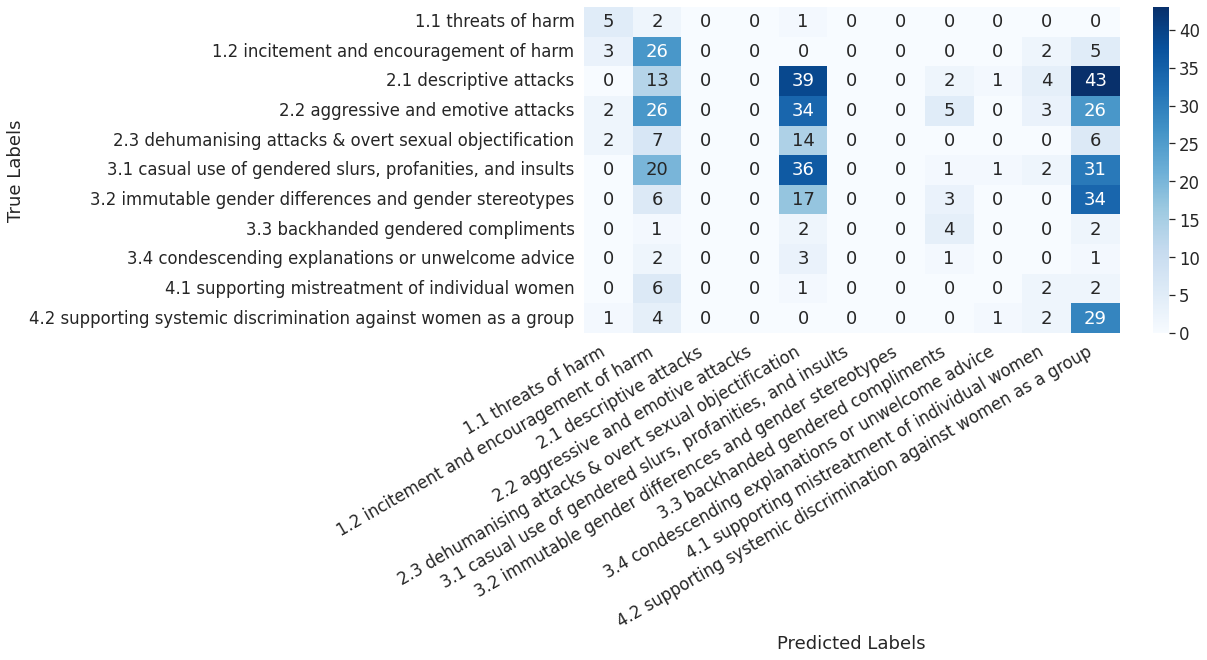

In [ ]:
# Uncomment depending on the sub-task and comment the rest
#predicted_labels = test(model, dev_dataloader_task_a)
#predicted_labels = test(model, dev_dataloader_task_b)
predicted_labels = test(model, dev_dataloader_task_c)

In [ ]:
# Uncomment depending on the sub-task and comment the rest
#development_set_a_predictions = pd.concat([sexism_dev_task_a.rewire_id, predicted_labels], axis = 1)
#development_set_a_predictions.label_pred.replace(id_to_labels_task_a, inplace = True)
#development_set_a_predictions.to_csv(args['results_data_directory'] + 'dev_set_predictions_BERT_Focal_BiLSTM_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')

#development_set_b_predictions = pd.concat([sexism_dev_task_b.rewire_id, predicted_labels], axis = 1)
#development_set_b_predictions.label_pred.replace(id_to_labels_task_b, inplace = True)
#development_set_b_predictions.to_csv(args['results_data_directory'] + 'dev_set_predictions_BERT_Focal_BiLSTM_task_b.csv', encoding = 'utf-8', index = False, header = True, sep =',')

development_set_c_predictions = pd.concat([sexism_dev_task_c.rewire_id, predicted_labels], axis = 1)
development_set_c_predictions.label_pred.replace(id_to_labels_task_c, inplace = True)
development_set_c_predictions.to_csv(args['results_data_directory'] + 'dev_set_predictions_ROBERTA_BiLSTM_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')

**PREDICT LABELS FOR TEST SETS (LABELLED TEST SETS)**

In [ ]:
# Uncomment the test labelled dataloader depending on the sub-task
#test_dataloader_task_a = create_data_loader(df = sexism_test_set_labelled_test_task_a, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')
#test_dataloader_task_b = create_data_loader(df = sexism_test_set_labelled_test_task_b, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')
test_dataloader_task_c = create_data_loader(df = sexism_test_set_labelled_test_task_c, tokenizer = tokenizer, max_len = args['max_seq_length'], batch_size = args['batch_size'], shuffle = False, sampler = 'test')

Predicting labels for 61 test sentences...


Evaluation iteration: 100%|██████████| 61/61 [00:15<00:00,  3.89it/s]



Calculating metrics...
Accuracy: 0.16804123711340208
F1 score: 0.15131646699615384
Precision: 0.4796600637332979
Recall : 0.2788405218109616
Matthews Correlation Coefficient: 0.13293159543861277

Precision of each class: [0.44444444 0.25       1.         1.         0.10334347 1.
 1.         0.03030303 0.         0.27586207 0.17230769]
Recall of each class: [0.5        0.76712329 0.         0.         0.59649123 0.
 0.         0.05555556 0.         0.38095238 0.76712329]
F1 score of each class: [0.47058824 0.37710438 0.         0.         0.1761658  0.
 0.         0.03921569 0.         0.32       0.28140704]
                                                                 precision    recall  f1-score   support

                                            1.1 threats of harm       0.44      0.50      0.47        16
                       1.2 incitement and encouragement of harm       0.25      0.77      0.38        73
                                        2.1 descriptive attacks     

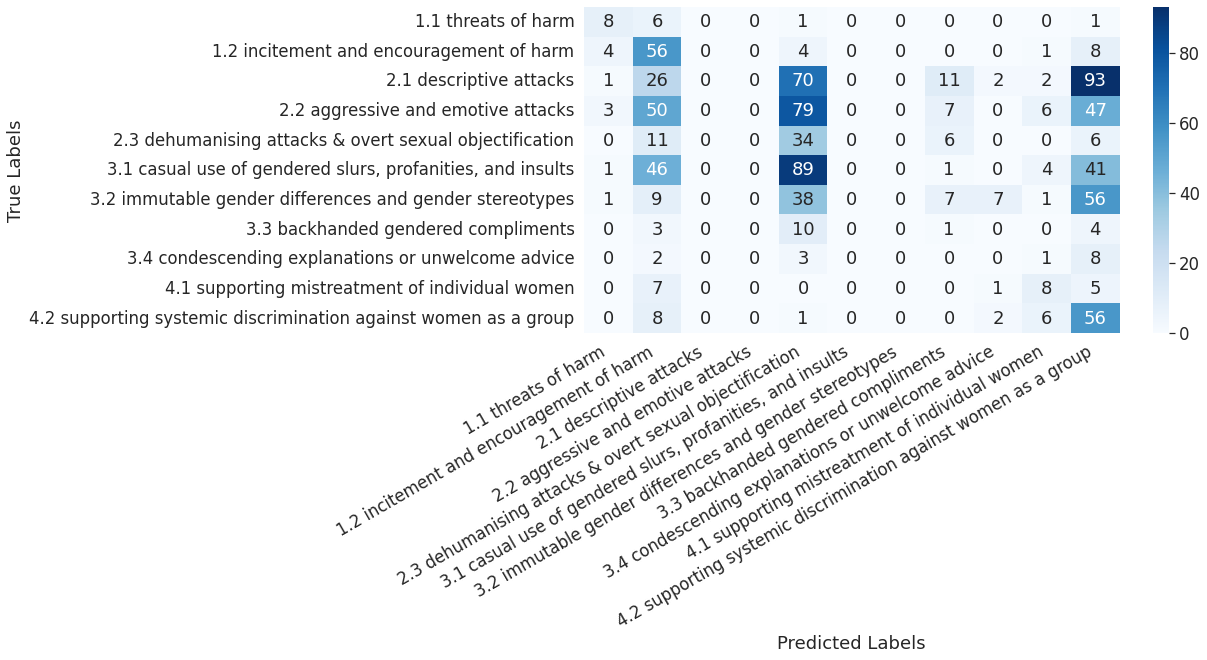

In [ ]:
# Uncomment depending on the sub-task and comment the rest
#predicted_labels_test_task_a = test(model, test_dataloader_task_a)
#predicted_labels_test_task_b = test(model, test_dataloader_task_b)
predicted_labels_test_task_c = test(model, test_dataloader_task_c)

In [ ]:
# Uncomment depending on the sub-task and comment the rest
#test_set_a_predictions = pd.concat([sexism_test_set_labelled_test_task_a.rewire_id, predicted_labels_test_task_a], axis = 1)
#test_set_a_predictions.label_pred.replace(id_to_labels_task_a, inplace = True)
#test_set_a_predictions.to_csv(args['results_data_directory'] + 'test_set_predictions_ROBERTA1_Last_Hidden_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')

#test_set_b_predictions = pd.concat([sexism_test_set_labelled_test_task_b.rewire_id, predicted_labels_test_task_b], axis = 1)
#test_set_b_predictions.label_pred.replace(id_to_labels_task_b, inplace = True)
#test_set_b_predictions.to_csv(args['results_data_directory'] + 'test_set_predictions_ROBERTA_Last_Hidden_task_b.csv', encoding = 'utf-8', index = False, header = True, sep =',')

#test_set_c_predictions = pd.concat([sexism_test_set_labelled_test_task_c.rewire_id, predicted_labels_test_task_c], axis = 1)
#test_set_c_predictions.label_pred.replace(id_to_labels_task_c, inplace = True)
#test_set_c_predictions.to_csv(args['results_data_directory'] + 'test_set_predictions_ROBERTA_Last_Hidden_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')

**PREDICT LABELS FOR TEST SETS (UNLABELLED TEST SETS)**

In [ ]:
'''
predicted_labels_task_a, test_file_task_a = model_evaluation_unlabelled(file = '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_a_entries.csv', 
                                                  model = model, 
                                                  id_2_label = id_to_labels_task_a, 
                                                  saved_filename = args['results_data_directory'] + 'test_set_task_a_predictions_BERT_Focal_BiLSTM.csv')
'''                                               

"\npredicted_labels_task_a, test_file_task_a = model_evaluation_unlabelled(file = '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_a_entries.csv', \n                                                  model = model, \n                                                  id_2_label = id_to_labels_task_a, \n                                                  saved_filename = args['results_data_directory'] + 'test_set_task_a_predictions_BERT_Focal_BiLSTM.csv')\n"

In [ ]:
'''
predicted_labels_task_b, test_file_task_b = model_evaluation_unlabelled(file = '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_b_entries.csv', 
                                                  model = model, 
                                                  id_2_label = id_to_labels_task_b, 
                                                  saved_filename = args['results_data_directory'] + 'test_set_task_b_predictions_BERT_Focal_BiLSTM.csv')
'''                                              

"\npredicted_labels_task_b, test_file_task_b = model_evaluation_unlabelled(file = '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_b_entries.csv', \n                                                  model = model, \n                                                  id_2_label = id_to_labels_task_b, \n                                                  saved_filename = args['results_data_directory'] + 'test_set_task_b_predictions_BERT_Focal_BiLSTM.csv')\n"

In [ ]:

predicted_labels_task_c, test_file_task_c = model_evaluation_unlabelled(file = '/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_c_entries.csv', 
                                                  model = model, 
                                                  id_2_label = id_to_labels_task_c, 
                                                  saved_filename = args['results_data_directory'] + 'test_set_task_c_predictions_ROBERTA_BiLSTM.csv')
                                          

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/test_data/test_task_c_entries.csv']
rewire_id                       970
text                            970
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 970 entries, 0 to 969
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rewire_id  970 non-null    object
 1   text       970 non-null    object
dtypes: object(2)
memory usage: 15.3+ KB
Maximum sentence length:  81
Minimum sentence length:  5
Predicting labels for 61 test sentences...


Evaluation iteration: 100%|██████████| 61/61 [00:15<00:00,  3.90it/s]


In [ ]:
task_a_labelled_test = pd.merge(test_file_task_a, sexism_test_set_labelled_test_task_a, on ='rewire_id')
task_a_labelled_test_final = task_a_labelled_test.drop('text_y', axis=1)
task_a_labelled_test_final = task_a_labelled_test_final.rename({'text_x':'text'}, axis = 1)

task_b_labelled_test = pd.merge(test_file_task_b, sexism_test_set_labelled_test_task_b, on ='rewire_id')
task_b_labelled_test_final = task_b_labelled_test.drop('text_y', axis=1)
task_b_labelled_test_final = task_b_labelled_test_final.rename({'text_x':'text'}, axis = 1)

task_c_labelled_test = pd.merge(test_file_task_c, sexism_test_set_labelled_test_task_c, on ='rewire_id')
task_c_labelled_test_final = task_c_labelled_test.drop('text_y', axis=1)
task_c_labelled_test_final = task_c_labelled_test_final.rename({'text_x':'text'}, axis = 1)

**GET THE FINAL PREDICTIONS THROUGH ENSEMBLE MAJORITY VOTE (DEVELOPMENT & TEST SETS)**

**SUB-TASK A**

In [ ]:
'''
# Predictions on developmemt provided set for sub-task A
model_1_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albert_last_hidden.csv', labelled_dataset = False)
model_2_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albert_weighted_pooling.csv', labelled_dataset = False)
model_3_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albert_concat4.csv', labelled_dataset = False)
model_4_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albert_bilstm.csv', labelled_dataset = False)

# Majority Vote Ensemble on development provided set for sub-task A
merged_preds_dev = pd.concat([model_1_dev.label_pred, model_2_dev.label_pred, model_3_dev.label_pred, model_4_dev.label_pred], axis = 1)
merged_preds_dev.replace(labels_to_id_task_a, inplace = True) 
merged_preds_dev = merged_preds_dev.to_numpy()

majority_vote_preds_dev = []
for i in range(merged_preds_dev.shape[0]):
  majority_vote_preds_dev.append(Counter(merged_preds_dev[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_dev = pd.DataFrame({'label_pred': majority_vote_preds_dev})

df_majority_vote_preds_dev.label_pred.replace(id_to_labels_task_a, inplace = True)
majority_vote_preds_id_labels = pd.concat([sexism_dev_task_a.rewire_id, df_majority_vote_preds_dev], axis = 1)
#majority_vote_preds_id_labels.to_csv(args['results_data_directory'] + '6_majority_vote_dev_preds_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')
majority_vote_preds_id_labels
majority_vote_preds_id_labels.replace(labels_to_id_task_a, inplace = True) 
calculate_metrics(sexism_dev_task_a.label, majority_vote_preds_id_labels.label_pred)
'''

Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/continue/dev_set_predictions_ROBERTA_Focal_Last_Hidden_task_c.csv']
rewire_id                       486
label_pred                       11
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 486 entries, 0 to 485
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   rewire_id   486 non-null    object
 1   label_pred  486 non-null    object
dtypes: object(2)
memory usage: 7.7+ KB
File or directory not accessible. Please check the entered path of the file.
File or directory not accessible. Please check the entered path of the file.
File or directory not accessible. Please check the entered path of the file.
Current file opened:  ['/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/continue/dev_set_predictions_BERT_Focal_ConcatLast4Hidden_task_b.csv']
rewire_id                       486
label_pred                        4
<c

In [ ]:
'''
# Predictions on test provided set for sub-task A
model_1 =  read_a_file(args['results_data_directory'] + 'test_set_task_a_predictions_albert_last_hidden.csv', labelled_dataset = False)
model_2 =  read_a_file(args['results_data_directory'] + 'test_set_task_a_predictions_albert_concat4.csv', labelled_dataset = False)
model_3 =  read_a_file(args['results_data_directory'] + 'test_set_task_a_predictions_albert_weighted_pooling.csv', labelled_dataset = False)
model_4 =  read_a_file(args['results_data_directory'] + 'test_set_task_a_predictions_albert_bilstm.csv', labelled_dataset = False)

# Majority Vote Ensemble on test provided set for sub-task A
merged_preds = pd.concat([model_1.label_pred, model_2.label_pred, model_3.label_pred, model_4.label_pred], axis = 1)
merged_preds.replace(labels_to_id_task_a, inplace = True)  
merged_preds = merged_preds.to_numpy()

majority_vote_preds_test = []
for i in range(merged_preds.shape[0]):
  majority_vote_preds_test.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_test = pd.DataFrame({'label_pred': majority_vote_preds_test})

#df_majority_vote_preds_test.label_pred.replace(id_to_labels_task_a, inplace = True)
majority_vote_preds_id_labels_test = pd.concat([task_a_labelled_test_final.rewire_id, df_majority_vote_preds_test], axis = 1)
#majority_vote_preds_id_labels_test.to_csv(args['results_data_directory'] + 'majority_vote_3_test_models_preds_task_a.csv', encoding = 'utf-8', index = False, header = True, sep =',')
majority_vote_preds_id_labels_test
majority_vote_preds_id_labels_test.replace(labels_to_id_task_a, inplace = True) 
test_f1_task_a = f1_score(y_true = task_a_labelled_test_final.label, y_pred = df_majority_vote_preds_test.label_pred, average='macro')
calculate_metrics(task_a_labelled_test_final.label, df_majority_vote_preds_test.label_pred)
'''

**SUB-TASK B**

In [ ]:
'''
# Predictions on development provided set for sub-task B
model_1_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albert_Last_Hidden_task_b.csv')
model_2_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_bert_BiLSTM_task_b.csv')
model_3_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albertx1large_Weighted_Pooling_task_b.csv')
model_4_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_bert_lasthidden_task_b.csv') 
model_5_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_RoBERTa_Last_Hidden_task_b.csv')
model_6_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_RoBERTa_Weighted_Pooling_task_b.csv')
model_7_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_ROBERTA_WeightedRandomSampler_Weighted_Pooling_task_b.csv')
model_8_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_bert_weighted_pooling_task_b.csv')
model_9_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_albertx1large_BiLSTM_task_b.csv')

# Majority Vote Ensemble on development provided set for sub-task C
merged_preds_dev = pd.concat([model_1_dev.label_pred, model_2_dev.label_pred, model_3_dev.label_pred, model_4_dev.label_pred, model_5_dev.label_pred, model_6_dev.label_pred, model_7_dev.label_pred, model_8_dev.label_pred, model_9_dev.label_pred], axis = 1)
  
merged_preds_dev.replace(labels_to_id_task_b, inplace = True) 
merged_preds_dev = merged_preds_dev.to_numpy()

majority_vote_preds_dev = []
for i in range(merged_preds_dev.shape[0]):
  majority_vote_preds_dev.append(Counter(merged_preds_dev[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_dev = pd.DataFrame({'label_pred': majority_vote_preds_dev})

df_majority_vote_preds_dev.label_pred.replace(id_to_labels_task_b, inplace = True)
majority_vote_preds_id_labels = pd.concat([sexism_dev_task_b.rewire_id, df_majority_vote_preds_dev], axis = 1)
#majority_vote_preds_id_labels.to_csv(args['results_data_directory'] + 'NINE_majority_vote_dev_preds_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')
calculate_metrics(sexism_dev_task_b.label, majority_vote_preds_id_labels.label_pred)
'''

In [ ]:
'''
# Predictions on test provided set for sub-task B
model_1 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ALBERT_v2_Last_Hidden.csv', labelled_dataset = False)
model_2 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ALBERT_v1_Last_Hidden.csv', labelled_dataset = False)
model_3 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ALBERT_v2_BiLSTM.csv', labelled_dataset = False)
model_4 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_BERT_Last_Hidden.csv', labelled_dataset = False) 
model_5 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_BERT_BiLSTM.csv', labelled_dataset = False)
model_6 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_BERT_Weighted_Pooling.csv', labelled_dataset = False)
model_7 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ROBERTA_Last_Hidden.csv', labelled_dataset = False)
model_8 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ROBERTA_Weighted_Pooling.csv', labelled_dataset = False)
model_9 =  read_a_file(args['results_data_directory'] + 'test_set_task_b_predictions_ROBERTA_test_set_task_b_predictions_ROBERTA_WeightedRandomSampler_Weighted_Pooling.csv', labelled_dataset = False)

# Majority Vote Ensemble on test provided set for sub-task B
merged_preds = pd.concat([model_1.label_pred, model_2.label_pred, model_3.label_pred, model_4.label_pred, model_5.label_pred, model_6.label_pred, model_7.label_pred, model_8.label_pred, model_9.label_pred], axis = 1)
merged_preds.replace(labels_to_id_task_b, inplace = True)  
merged_preds = merged_preds.to_numpy()

majority_vote_preds = []
for i in range(merged_preds.shape[0]):
  majority_vote_preds.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_test = pd.DataFrame({'label_pred': majority_vote_preds})

df_majority_vote_preds_test.label_pred.replace(id_to_labels_task_b, inplace = True)
majority_vote_preds_id_labels_test = pd.concat([test_file_task_b.rewire_id, df_majority_vote_preds_test], axis = 1)
#majority_vote_preds_id_labels_test.to_csv(args['results_data_directory'] + 'majority_vote_NINE_test_models_preds_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')
calculate_metrics(task_b_labelled_test_final.label, majority_vote_preds_id_labels_test.label_pred)
'''

**SUB-TASK C**

In [ ]:
'''
# Predictions on development provided set for sub-task C
model_1_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_RoBERTa_Last_Hidden_task_c.csv', labelled_dataset = False)
model_2_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_BERT_Weighted_Pooling_task_c.csv', labelled_dataset = False)
model_3_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_BERT_Last_Hidden_task_c.csv', labelled_dataset = False)
model_4_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_BERT_BiLSTM_task_c.csv', labelled_dataset = False) 
model_5_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_ALBERT_v1_Last_Hidden_task_c.csv', labelled_dataset = False)
model_6_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_RoBERTa_BiLSTM_task_c.csv', labelled_dataset = False)
model_7_dev =  read_a_file(args['results_data_directory'] + 'dev_set_predictions_ALBERT_v2_Weighted_Pooling_task_c.csv', labelled_dataset = False)

# Majority Vote Ensemble on development provided set for sub-task C
merged_preds_dev = pd.concat([model_1_dev.label_pred, model_2_dev.label_pred, model_3_dev.label_pred, model_4_dev.label_pred, model_5_dev.label_pred, model_6_dev.label_pred, model_7_dev.label_pred], axis = 1)
  
merged_preds_dev.replace(labels_to_id_task_c, inplace = True) 
merged_preds_dev = merged_preds_dev.to_numpy()

majority_vote_preds_dev = []
for i in range(merged_preds_dev.shape[0]):
  majority_vote_preds_dev.append(Counter(merged_preds_dev[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_dev = pd.DataFrame({'label_pred': majority_vote_preds_dev})

df_majority_vote_preds_dev.label_pred.replace(id_to_labels_task_c, inplace = True)
majority_vote_preds_id_labels = pd.concat([sexism_dev_task_c.rewire_id, df_majority_vote_preds_dev], axis = 1)
#majority_vote_preds_id_labels.to_csv(args['results_data_directory'] + 'SEVEN_majority_vote_dev_preds_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')
calculate_metrics(sexism_dev_task_c.label, majority_vote_preds_id_labels.label_pred)
'''

In [ ]:
'''
# Predictions on test provided set for sub-task C
model_1 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_RoBERTa_Last_Hidden.csv', labelled_dataset = False)
model_2 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_BERT_BiLSTM.csv', labelled_dataset = False)
model_3 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_BERT_Last_Hidden.csv', labelled_dataset = False)
model_4 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_BERT_Weighted_Pooling.csv', labelled_dataset = False) 
model_5 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_RoBERTa_BiLSTM.csv', labelled_dataset = False)
model_6 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_ALBERT_v2_Weighted_Pooling.csv', labelled_dataset = False)
model_7 =  read_a_file(args['results_data_directory'] + 'test_set_task_c_predictions_ALBERT_v1_Last_Hidden.csv', labelled_dataset = False)

# Majority Vote Ensemble on test provided set for sub-task C
merged_preds = pd.concat([model_1.label_pred, model_2.label_pred, model_3.label_pred, model_4.label_pred, model_5.label_pred, model_6.label_pred, model_7.label_pred], axis = 1)
merged_preds.replace(labels_to_id_task_c, inplace = True)  
merged_preds = merged_preds.to_numpy()

majority_vote_preds = []
for i in range(merged_preds.shape[0]):
  majority_vote_preds.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_test = pd.DataFrame({'label_pred': majority_vote_preds})

df_majority_vote_preds_test.label_pred.replace(id_to_labels_task_c, inplace = True)
majority_vote_preds_id_labels_test = pd.concat([test_file_task_c.rewire_id, df_majority_vote_preds_test], axis = 1)
#majority_vote_preds_id_labels_test.to_csv(args['results_data_directory'] + 'majority_vote_SEVEN_test_models_preds_task_c.csv', encoding = 'utf-8', index = False, header = True, sep =',')
calculate_metrics(task_c_labelled_test_final.label, majority_vote_preds_id_labels_test.label_pred)
'''

**GET TRUE PREDICTIONS FROM TEST SETS (AFTER THE END OF THE SHARED TASK)**

In [ ]:
'''
model_1_old =  read_a_file('/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/task_a/test_set_task_a_predictions_albert_weighted_pooling.csv', labelled_dataset = False)
model_2_old =  read_a_file('/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/task_a/test_set_task_a_predictions_albert_last_hidden.csv', labelled_dataset = False)
model_3_old =  read_a_file('/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/task_a/test_set_task_a_predictions_albert_concat4.csv', labelled_dataset = False)
model_4_old =  read_a_file('/content/drive/MyDrive/ColabNotebooks/SEMEVAL_2023_SEXISM/results/task_a/test_set_task_a_predictions_albert_bilstm.csv', labelled_dataset = False)

merged_preds = pd.concat([model_1_old.label_pred, model_2_old.label_pred, model_3_old.label_pred, model_4_old.label_pred], axis = 1)
merged_preds.replace(labels_to_id_task_a, inplace = True)  
merged_preds = merged_preds.to_numpy()

majority_vote_preds_test = []
for i in range(merged_preds.shape[0]):
  majority_vote_preds_test.append(Counter(merged_preds[i].astype(int)).most_common(1)[0][0])

df_majority_vote_preds_test = pd.DataFrame({'label_pred': majority_vote_preds_test})

#df_majority_vote_preds_test.label_pred.replace(id_to_labels_task_a, inplace = True)
majority_vote_preds_id_labels_test = pd.concat([task_a_labelled_test_final.rewire_id, df_majority_vote_preds_test], axis = 1)
#majority_vote_preds_id_labels_test.to_csv(args['results_data_directory'] + 'TASK_A_FINAL_4_ENSEMBLE_MODELS_ALBERTX2.csv', encoding = 'utf-8', index = False, header = True, sep =',')
majority_vote_preds_id_labels_test
majority_vote_preds_id_labels_test.replace(labels_to_id_task_a, inplace = True) 
calculate_metrics(task_a_labelled_test_final.label, df_majority_vote_preds_test.label_pred)
'''

**REFERENCE SOURCE CODES**

https://pypi.org/project/focal-loss-torch/

https://github.com/ufoym/imbalanced-dataset-sampler

https://is-rajapaksha.medium.com/bert-word-embeddings-deep-dive-32f6214f02bf

https://www.kaggle.com/code/rhtsingh/utilizing-transformer-representations-efficiently


https://www.kaggle.com/code/joydeb28/text-classification-with-bert-pytorch